In [119]:
import pandas as pd
import river
from pprint import pprint
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
import itertools
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime as dt
from river import ensemble
from river import stream
from river import datasets
from matplotlib.pyplot import figure
from river import facto
from river import compat
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.tsa.stattools import adfuller, kpss
from river import metrics
import matplotlib.pyplot as plt
from river import tree
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from river import neighbors
from river import multioutput
import scipy.stats as stats
from river import neural_net
from river import dummy
from river import compat
from river import time_series
import numpy as np
import matplotlib.patches as mpatches
import time
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import scipy
%matplotlib inline

In [3]:
# caricamento dati ItalyPowerDemand

dati_test = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/ItalyPowerDemand(1)/ItalyPowerDemand_TEST.txt",delim_whitespace=True, index_col=False, header=0, names=('target','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))

dati_train = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/ItalyPowerDemand(1)/ItalyPowerDemand_TRAIN.txt", delim_whitespace=True, index_col=False, header=0, names=('target','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))

dati_train = dati_train.drop("target", axis= 1)
dati_test = dati_test.drop("target", axis= 1)

dati_train = dati_train.stack().reset_index()
dati_test = dati_test.stack().reset_index()

dati_train = dati_train.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'PowerDemandValue'})
dati_train = dati_train[['Count_days','Hours','PowerDemandValue']]

dati_test = dati_test.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'PowerDemandValue'})
dati_test = dati_test[['Count_days','Hours','PowerDemandValue']]

# concateno i due dataset almeno per quanto riguarda lo sviluppo di algoritmi online

dati_complete_italy = pd.concat([dati_train, dati_test])
list_hour = []
i = 0
for a in range(0, dati_complete_italy.shape[0]):
       list_hour.append(i)
       i +=1
       if(i == 24):
              i=0
dati_complete_italy['hour'] = list_hour
dati_complete_italy = dati_complete_italy[['Count_days', 'hour', 'PowerDemandValue']]
dati_complete_italy.to_csv('dati_PowerDemandValue')


dati_complete_italy = pd.read_csv('/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerDemandValue')



dati_complete_italy = dati_complete_italy[['Count_days', 'hour', 'PowerDemandValue']]
dati_complete_italy


def initial_iter_italy():

       path = '/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerDemandValue'

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'PowerDemandValue': float,
                     'hour': int
                     },
              target='PowerDemandValue'
                      )
       return X_y

## Descriptive statistics and pre processing


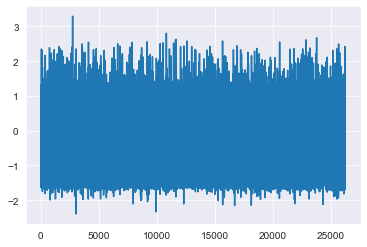

In [79]:
plt.plot(dati_complete_italy['PowerDemandValue'])

<AxesSubplot:xlabel='PowerDemandValue', ylabel='Count'>

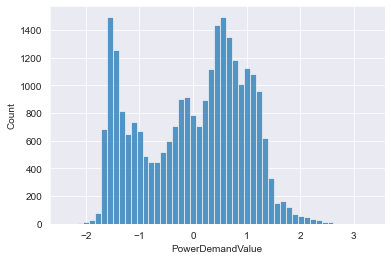

In [80]:
sns.histplot(dati_complete_italy['PowerDemandValue'])

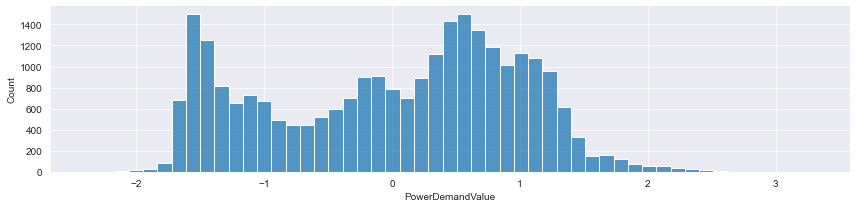

In [81]:
sns.displot(dati_complete_italy['PowerDemandValue'], kind='hist', height=3, aspect=4)

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PowerDemandValue'>

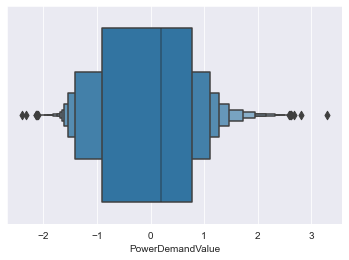

In [82]:
sns.boxenplot(dati_complete_italy['PowerDemandValue'])

In [85]:
def plot_outliers(outliers, data, method='KNN',halignment = 'right',valignment = 'bottom',labels=False):
    ax = data.plot(alpha=0.6)
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}',
                     horizontalalignment=halignment,
                     verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
        plt.title(f'Italy power demand - {method}')
        plt.xlabel('sample'); plt.ylabel('#Demand')
        plt.legend(['Italy Power Demand','outliers'])
        plt.show()

In [86]:
percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
dati_complete_italy['PowerDemandValue'].describe(percentiles= percentiles)

count    2.625600e+04
mean     8.003221e-11
std      9.789637e-01
min     -2.393368e+00
0%      -2.393368e+00
5%      -1.572627e+00
10%     -1.477563e+00
25%     -9.136894e-01
50%      1.967356e-01
75%      7.670679e-01
90%      1.174023e+00
95%      1.340390e+00
100%     3.293852e+00
max      3.293852e+00
Name: PowerDemandValue, dtype: float64

In [88]:
def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data['PowerDemandValue'] - data['PowerDemandValue'].mean())/data['PowerDemandValue'].std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]

    return outliers

In [89]:
threshold = 2.5
outliers = zscore(dati_complete_italy, threshold)

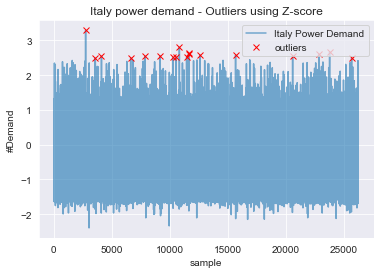

In [90]:
plot_outliers(outliers, dati_complete_italy['PowerDemandValue'], "Outliers using Z-score")

In [91]:
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [94]:
test_normal(dati_complete_italy['PowerDemandValue'])

Reject null hypothesis. Data is not normal


In [96]:
def modified_zscore(df, degree = 3):
    data = df.copy()
    s = stats.norm.ppf(0.75)
    numerator = s*(data['PowerDemandValue'] - data['PowerDemandValue'].median())
    MAD = np.abs(data['PowerDemandValue'] - data['PowerDemandValue'].median()).median()
    data['m_zscore'] = numerator/MAD
    outliers = data[(data['m_zscore'] > degree) | (data['m_zscore'] < -degree)]

    return outliers, data['PowerDemandValue']

In [97]:
threshold = 3
outliers, transformed = modified_zscore (dati_complete_italy, threshold)

<AxesSubplot:>

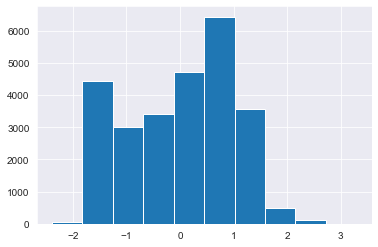

In [98]:
transformed.hist()

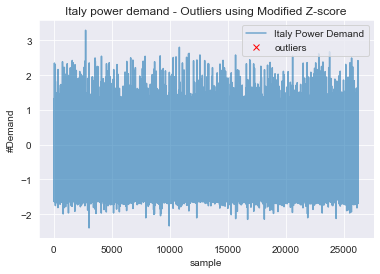

In [100]:
plot_outliers(outliers, dati_complete_italy['PowerDemandValue'], "Outliers using Modified Z-score")

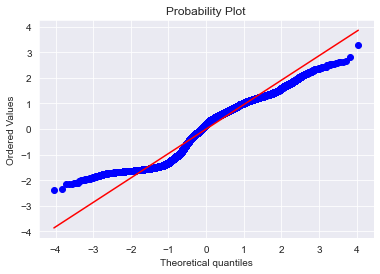

In [102]:
res = scipy.stats.probplot(dati_complete_italy['PowerDemandValue'].values.reshape(-1), plot=plt)

In [114]:
italy_power = seasonal_decompose(dati_complete_italy['PowerDemandValue'], model = 'additive', period=24)

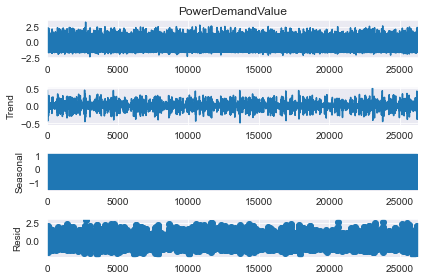

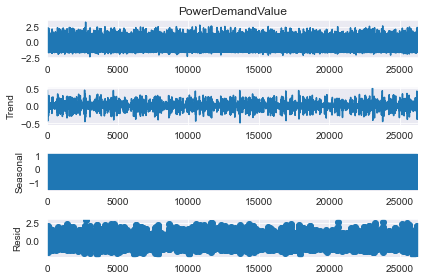

In [115]:
italy_power.plot()

In [116]:
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
    return pd.Series(output_dict, name=test)

In [117]:
adf_output = adfuller(dati_complete_italy['PowerDemandValue'])
kpss_output = kpss(dati_complete_italy['PowerDemandValue'])

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [118]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,-37.846324,0.010064
p-value,0.0,0.1
Numbers of lags,48,147
decision,Stationary,Stationary
Critical Value (1%),-3.4306,0.739
Critical Value (5%),-2.86165,0.463
Critical Value (10%),-2.566829,0.347
Critical Value (2.5%),NaN,0.574


# Italy Power Demand

## MLP Online vs MLP Batch


### MLP Online

100%|██████████| 26256/26256 [01:50<00:00, 238.21it/s]


Execution time: 110.2254250049591 seconds


Text(0.5, 1.0, 'MSE: 0.292127')

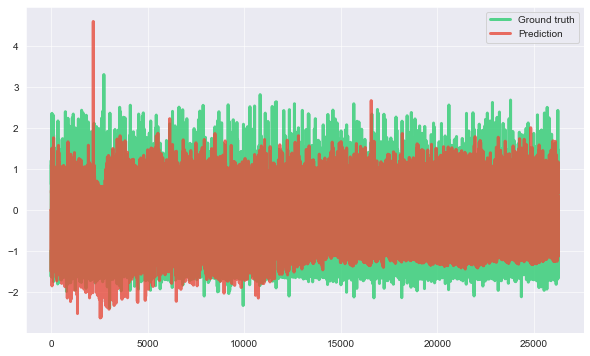

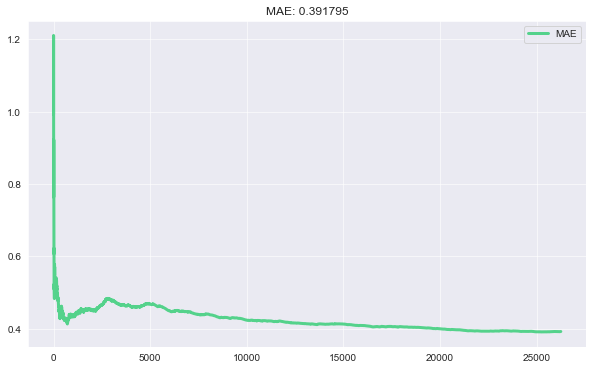

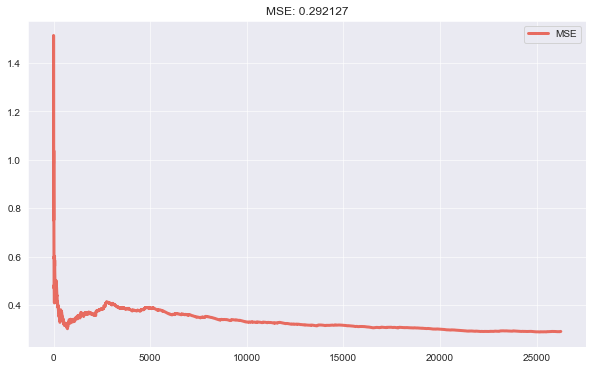

In [4]:
metric_mae_ml_online = metrics.MAE()
metric_mse_ml_online = metrics.MSE()

dates_ml_online = []
y_trues_ml_online = []
y_preds_ml_online = []
metrics_MAE_ml_online = []
metrics_MSE_ml_online = []

X_y = initial_iter_italy()

model = compose.Select('hour', 'Count_days')
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(256,128,64,32),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD(0.01)
       )
)

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric ultimo 30%
       metric_mae_ml_online.update(y, y_pred)
       metric_mse_ml_online.update(y, y_pred)
       metrics_MAE_ml_online.append(metric_mae_ml_online.get())
       metrics_MSE_ml_online.append(metric_mse_ml_online.get())

       # Store the true value and the prediction
       dates_ml_online.append(i)
       y_trues_ml_online.append(y)
       y_preds_ml_online.append(y_pred)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, y_trues_ml_online, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_ml_online, y_preds_ml_online, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, metrics_MAE_ml_online, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_ml_online)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, metrics_MSE_ml_online, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_ml_online)

In [4]:
X_y = initial_iter_italy()
model = compose.Select('hour', 'Count_days')
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(256,128,64,32),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD(0.01)
       )
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       delay=3,
       print_every=3000
)

[3,000] MAE: 0.637474
[6,000] MAE: 0.59996
[9,000] MAE: 0.565972
[12,000] MAE: 0.533601
[15,000] MAE: 0.525294
[18,000] MAE: 0.509994
[21,000] MAE: 0.492838
[24,000] MAE: 0.48548


MAE: 0.480439

In [9]:
X_y = initial_iter_italy()
model = compose.Select('hour', 'Count_days')
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(256,128,64,32),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD(0.01)
       )
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       delay=3,
       print_every=3000
)

[3,000] MSE: 0.64482
[6,000] MSE: 0.585994
[9,000] MSE: 0.536234
[12,000] MSE: 0.489661
[15,000] MSE: 0.466962
[18,000] MSE: 0.450326
[21,000] MSE: 0.428816
[24,000] MSE: 0.420206


MSE: 0.415938

### MLP Batch

In [42]:
dati_complete_italy

,Count_days,hour,PowerDemandValue
0,0,0,-0.993009
1,0,1,-1.426786
2,0,2,-1.579884
3,0,3,-1.605401
4,0,4,-1.630917
...,...,...,...
26251,1027,19,0.180490
26252,1027,20,-0.094058
26253,1027,21,0.729587
26254,1027,22,0.210995


In [5]:

X_mlp = dati_complete_italy[['PowerDemandValue', 'hour', 'Count_days']].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_mlp, y_mlp = split_sequence(X_mlp, 1)

X_mlp = np.array(X_mlp).reshape((26255,3))

y_mlp = np.array(y_mlp)
y_mlp = y_mlp[:, [0]]

X_train_mlp, X_test_mlp, Y_train_mlp, Y_test_mlp = train_test_split(X_mlp, y_mlp, random_state=1, train_size=0.7, shuffle=False)

# get the start time
st = time.time()

regr_mlp = MLPRegressor(random_state=1, max_iter=2000, hidden_layer_sizes=(128,64,32)).fit(X_train_mlp, Y_train_mlp)



result_mlpBatch = regr_mlp.predict(X_test_mlp).reshape(-1,1)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 6.800181150436401 seconds


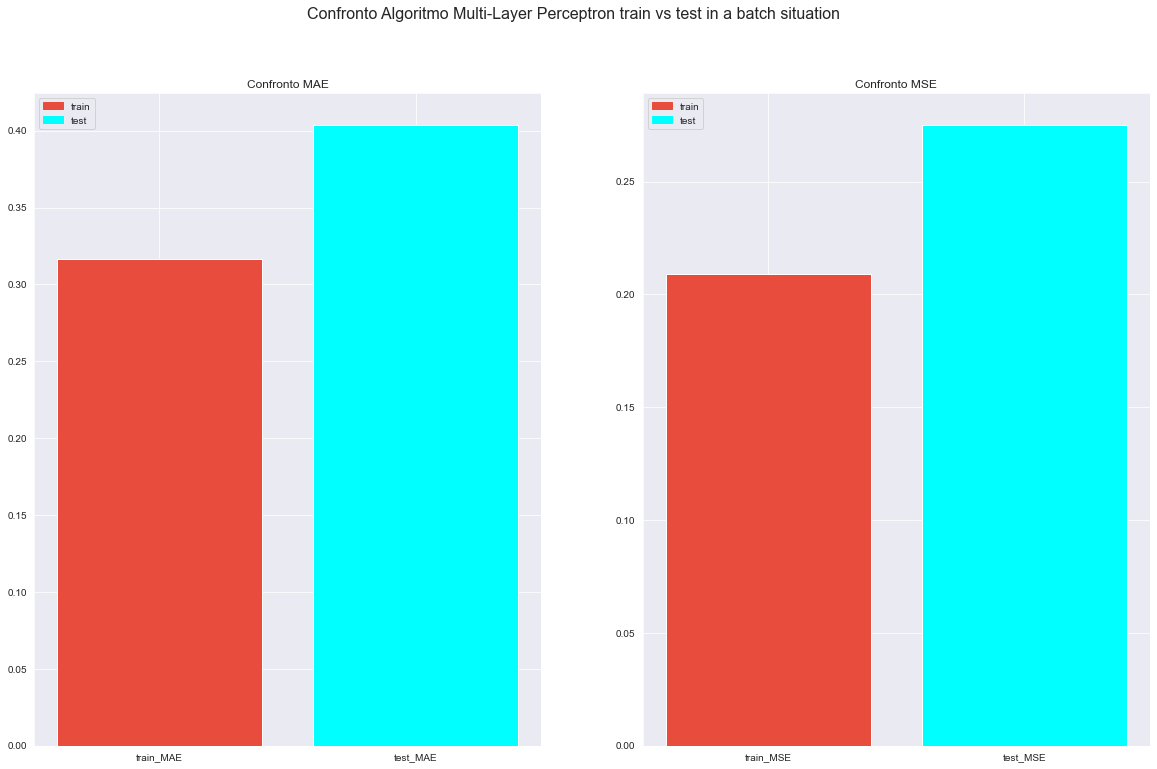

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron train vs test in a batch situation',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_train_mlp, regr_mlp.predict(X_train_mlp)),mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['train_MAE','test_MAE'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_train_mlp, regr_mlp.predict(X_train_mlp)),mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['train_MSE','test_MSE'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='train')
cyan_patch= mpatches.Patch(color='cyan', label='test')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

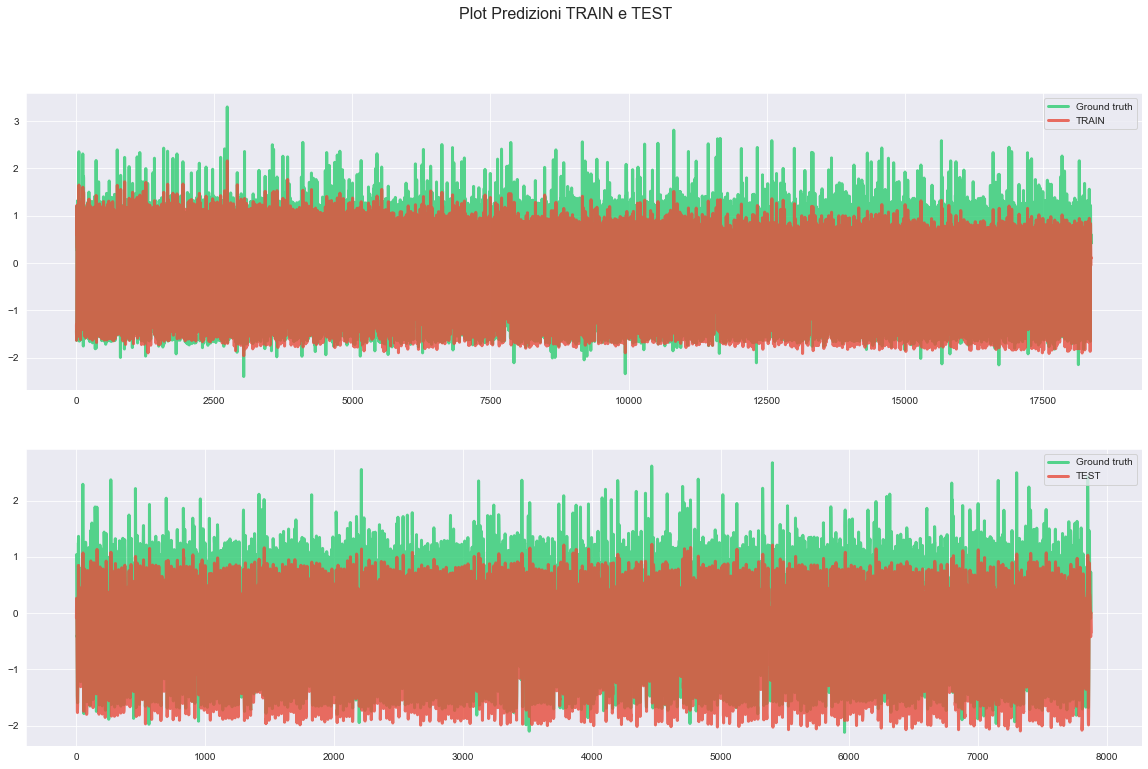

In [7]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Plot Predizioni TRAIN e TEST',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot( Y_train_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot( Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot( regr_mlp.predict(X_train_mlp), lw=3, color='#e74c3c', alpha=0.8, label='TRAIN')
ax2.plot( regr_mlp.predict(X_test_mlp), lw=3, color='#e74c3c', alpha=0.8, label='TEST')
ax1.legend()
ax2.legend()

### Confronto MLP Batch vs MLP Online


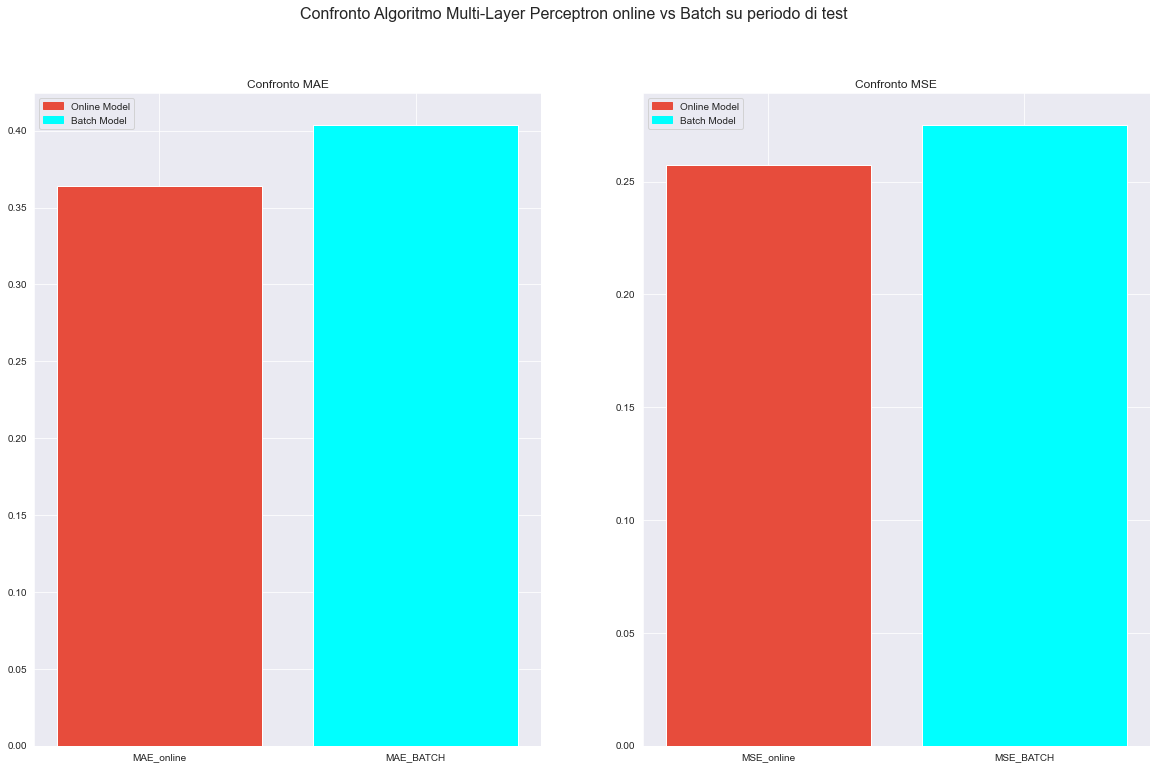

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron online vs Batch su periodo di test',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_test_mlp, y_preds_ml_online[18379::]),mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_test_mlp, y_preds_ml_online[18379::]),mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

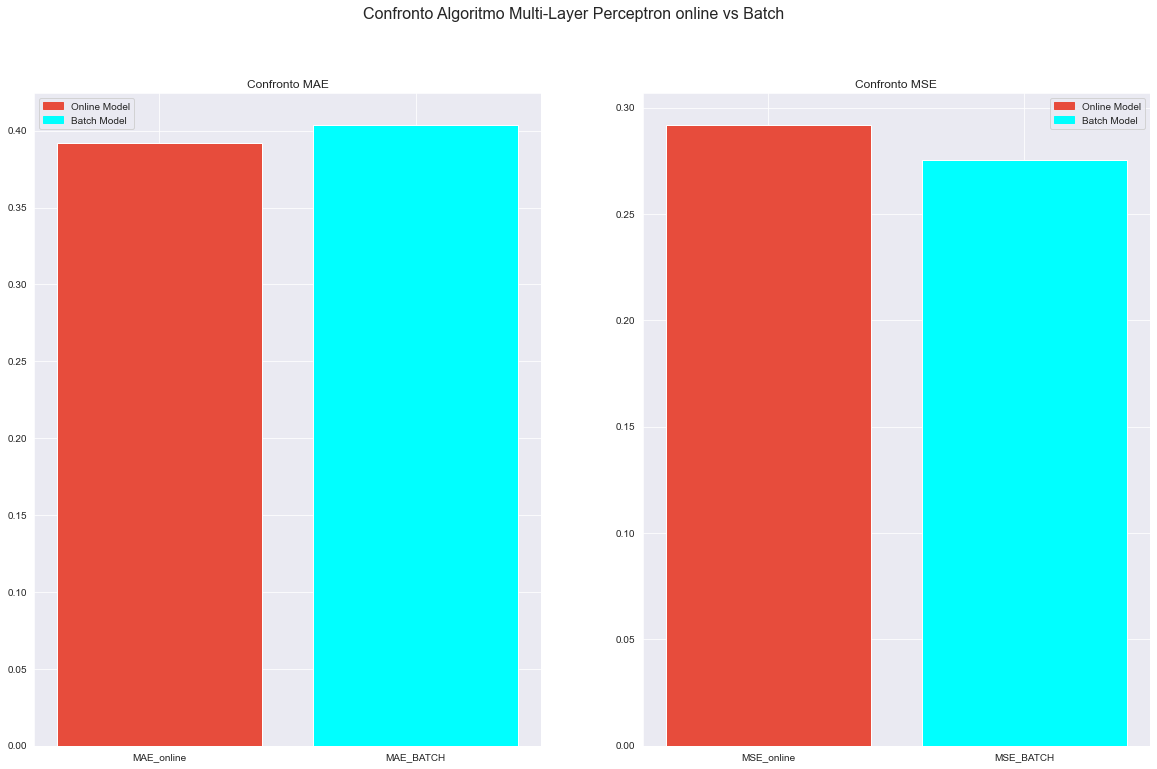

In [9]:
ax2.legend(handles=[red_patch, cyan_patch])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron online vs Batch', fontsize=16)

ax1.bar(height=[metrics_MAE_ml_online[-1], mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))],
        x=['MAE_online', 'MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_ml_online[-1], mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))],
        x=['MSE_online', 'MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch = mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

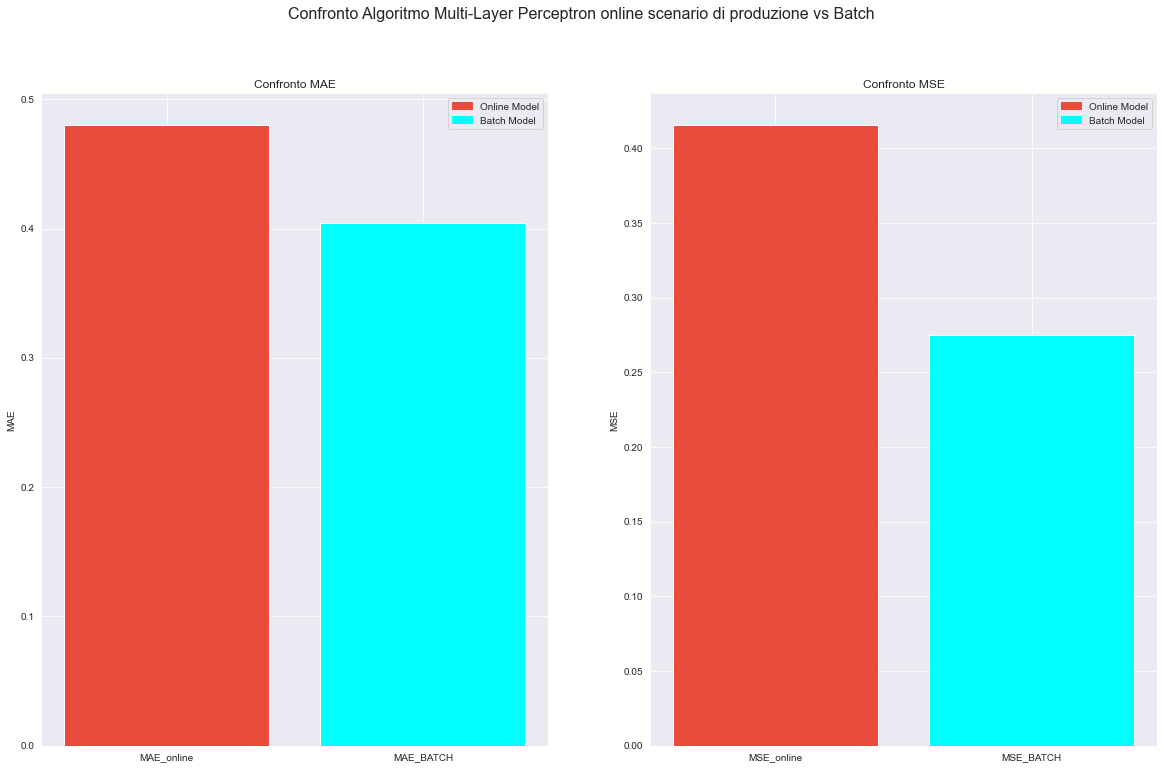

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron online scenario di produzione vs Batch',  fontsize=16)

ax1.bar(height=[0.480439,mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[0.415938,mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

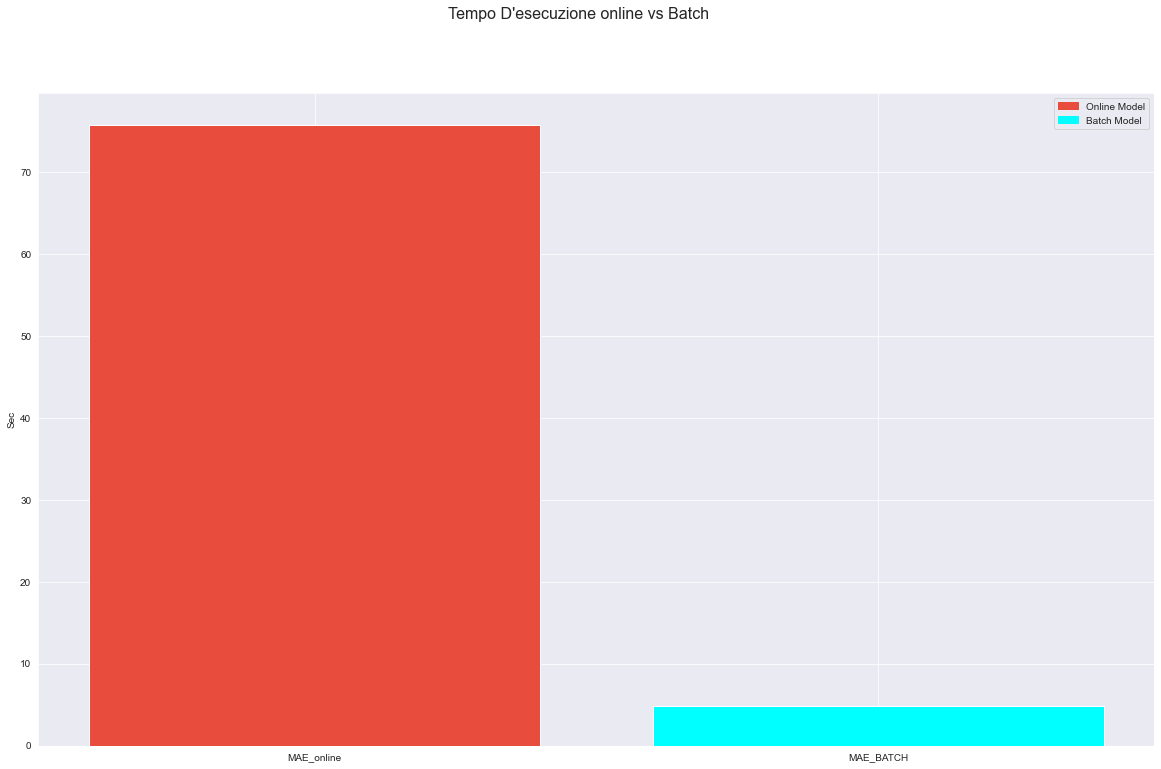

In [11]:
fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[75.8282904624939,4.870874404907227], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

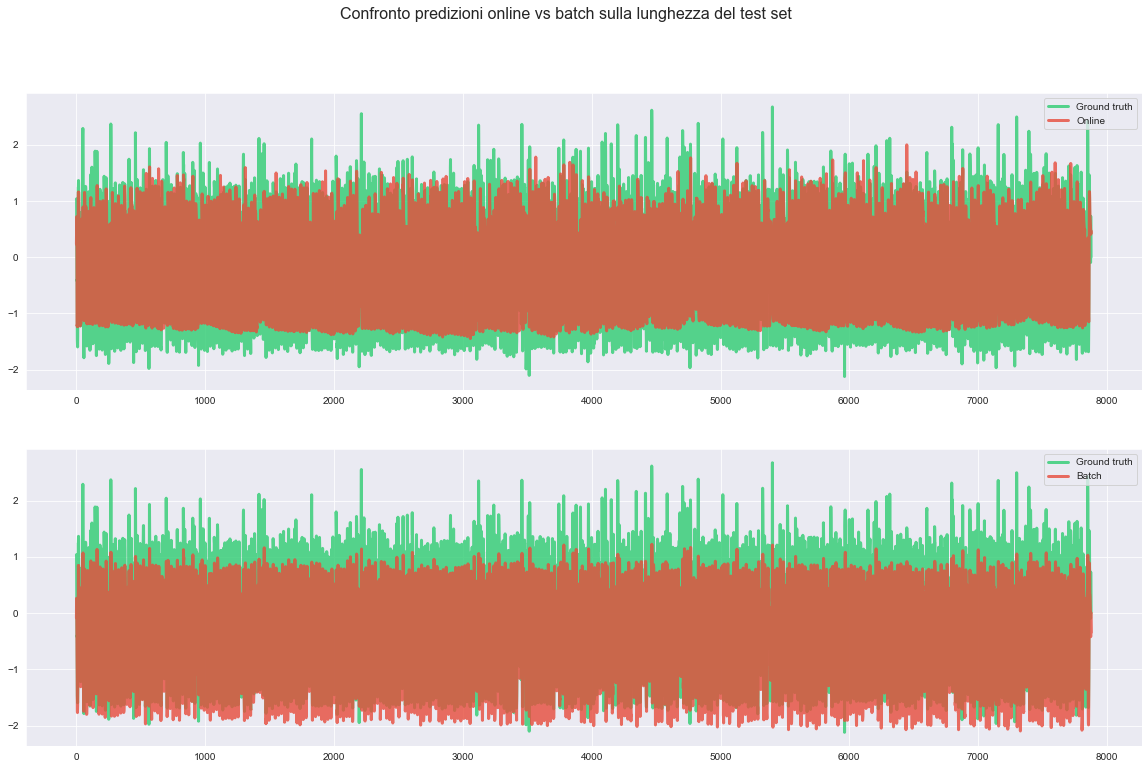

In [12]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot( Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot( Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot( y_preds_ml_online[18379::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot( result_mlpBatch, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()

## KNN Regressor Batch vs Online


### KNN regressor Online


100%|██████████| 26256/26256 [01:45<00:00, 249.51it/s]


Execution time: 105.23189401626587 seconds


Text(0.5, 1.0, 'MSE: 0.433091')

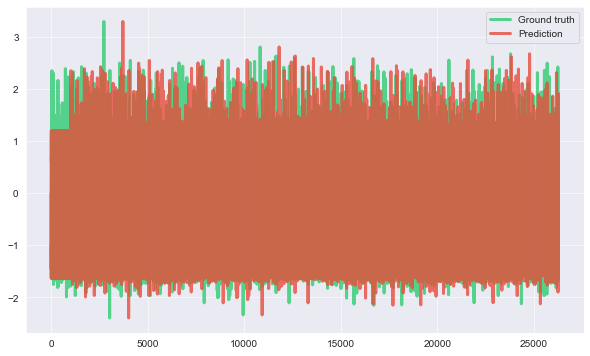

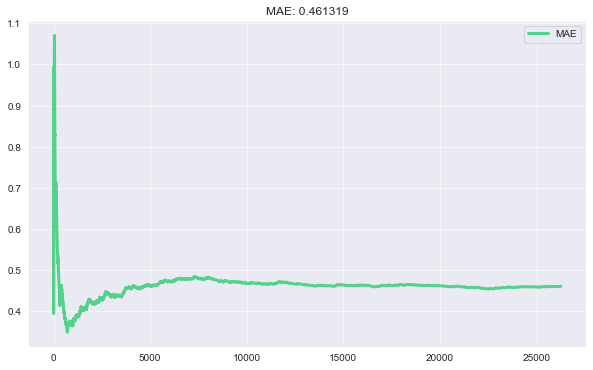

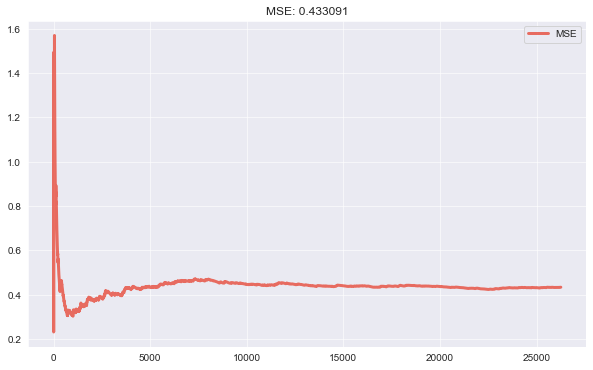

In [13]:
metric_mae_knnreg = metrics.MAE()
metric_mse_knnreg = metrics.MSE()

dates_knnreg = []
y_trues_knnreg = []
y_preds_knnreg = []
metrics_MAE_knnreg = []
metrics_MSE_knnreg = []

X_y = initial_iter_italy()
model = compose.Select('hour')
model |= neighbors.KNNRegressor(
       n_neighbors=10
)

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #26256
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go

       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_knnreg.update(y, y_pred)
       metric_mse_knnreg.update(y, y_pred)
       metrics_MAE_knnreg.append(metric_mae_knnreg.get())
       metrics_MSE_knnreg.append(metric_mse_knnreg.get())


       # Store the true value and the prediction
       dates_knnreg.append(i)
       y_trues_knnreg.append(y)
       y_preds_knnreg.append(y_pred)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, y_trues_knnreg, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_knnreg, y_preds_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, metrics_MAE_knnreg, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_knnreg)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, metrics_MSE_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_knnreg)

In [6]:
X_y = initial_iter_italy()
model = compose.Select('hour')
model |= neighbors.KNNRegressor(
       n_neighbors=10
)

evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MAE(),
       delay=3,
       print_every=3000
)

[3,000] MAE: 0.438964
[6,000] MAE: 0.474281
[9,000] MAE: 0.473929
[12,000] MAE: 0.470369
[15,000] MAE: 0.464115
[18,000] MAE: 0.465463
[21,000] MAE: 0.4609
[24,000] MAE: 0.458908


MAE: 0.461543

In [8]:
X_y = initial_iter_italy()
model = compose.Select('hour')
model |= neighbors.KNNRegressor(
       n_neighbors=10
)

evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MSE(),
       delay=3,
       print_every=3000
)

[3,000] MSE: 0.404232
[6,000] MSE: 0.453193
[9,000] MSE: 0.456858
[12,000] MSE: 0.450799
[15,000] MSE: 0.44001
[18,000] MSE: 0.441467
[21,000] MSE: 0.432679
[24,000] MSE: 0.430425


MSE: 0.433621

### KNN regressor Batch


In [14]:
X_knm = dati_complete_italy[['PowerDemandValue']].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_knm, y_knm = split_sequence(X_knm, 1)

X_knm = np.array(X_knm).reshape((26255,1))

X_train_knm, X_test_knm, Y_train_knm, Y_test_knm = train_test_split(X_knm, y_knm, random_state=1, train_size=0.7, shuffle=False)

# get the start time
st = time.time()

neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train_knm, Y_train_knm)

result_knnreg = neigh.predict(X_test_knm)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.031754493713378906 seconds


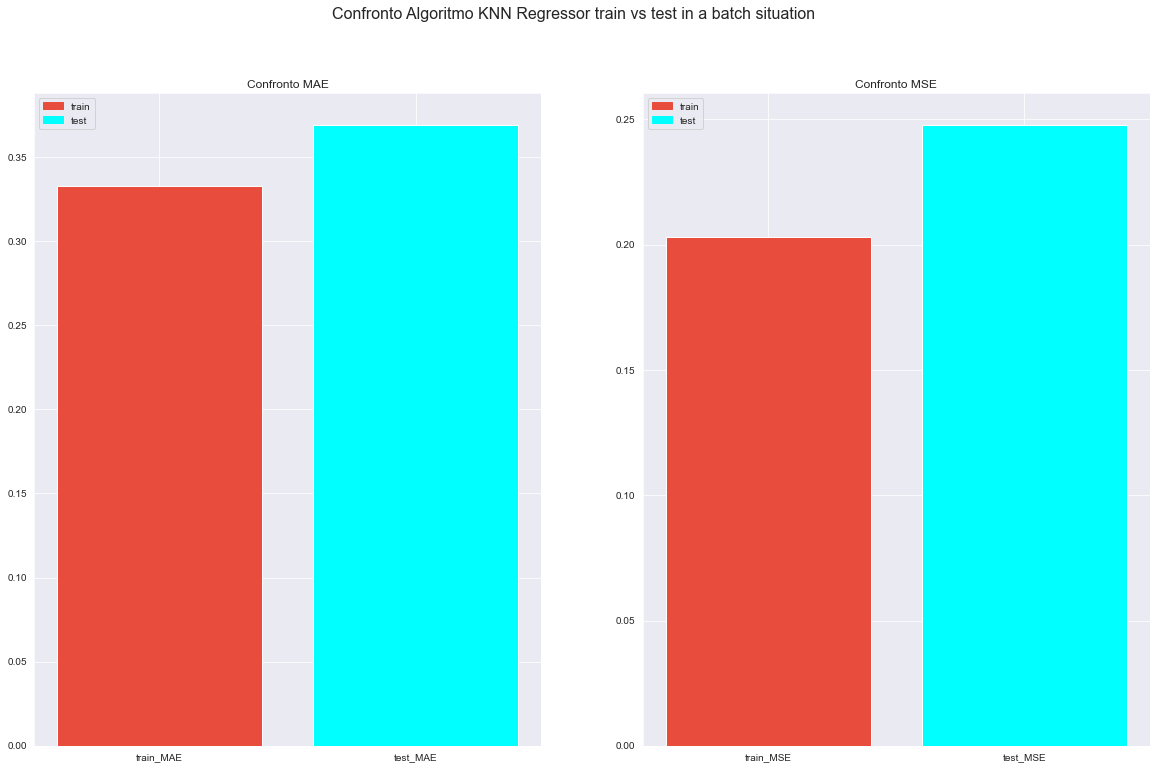

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN Regressor train vs test in a batch situation',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_train_knm, neigh.predict(X_train_knm)),mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['train_MAE','test_MAE'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_train_knm, neigh.predict(X_train_knm)),mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['train_MSE','test_MSE'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='train')
cyan_patch= mpatches.Patch(color='cyan', label='test')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

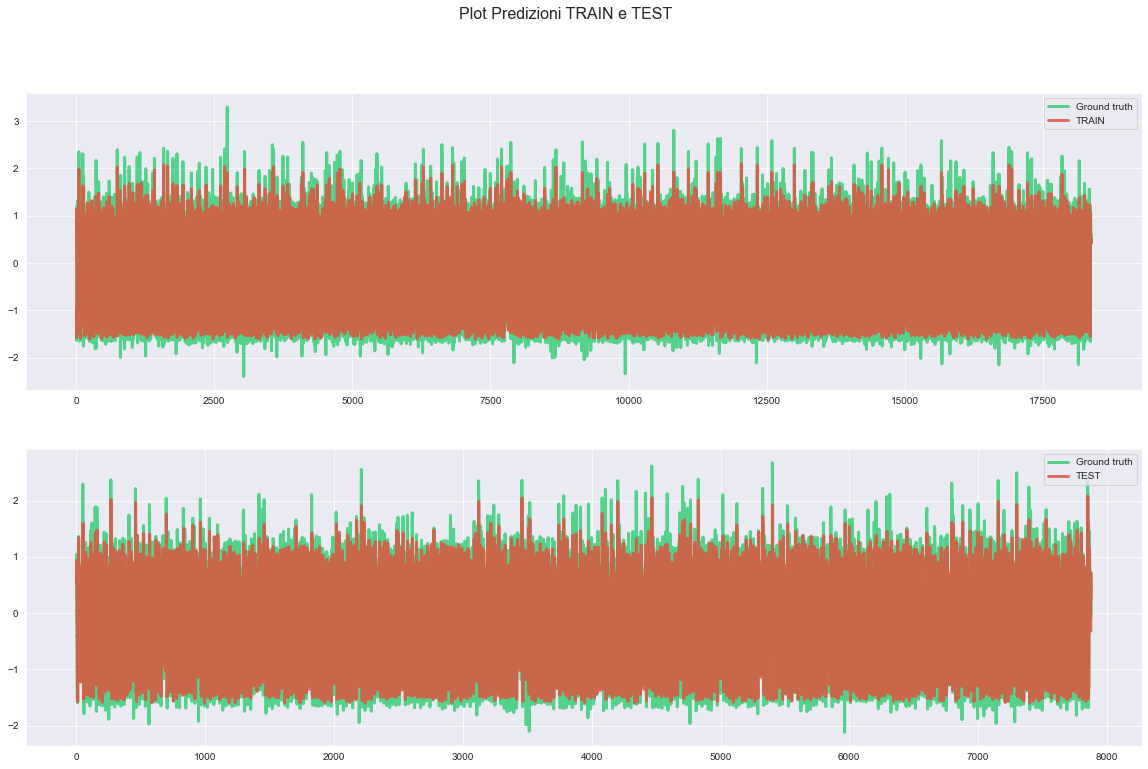

In [16]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Plot Predizioni TRAIN e TEST',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot( Y_train_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot( Y_test_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot( neigh.predict(X_train_knm), lw=3, color='#e74c3c', alpha=0.8, label='TRAIN')
ax2.plot( neigh.predict(X_test_knm), lw=3, color='#e74c3c', alpha=0.8, label='TEST')
ax1.legend()
ax2.legend()

### Confronto KNN regressor Batch vs KNN regressor Online


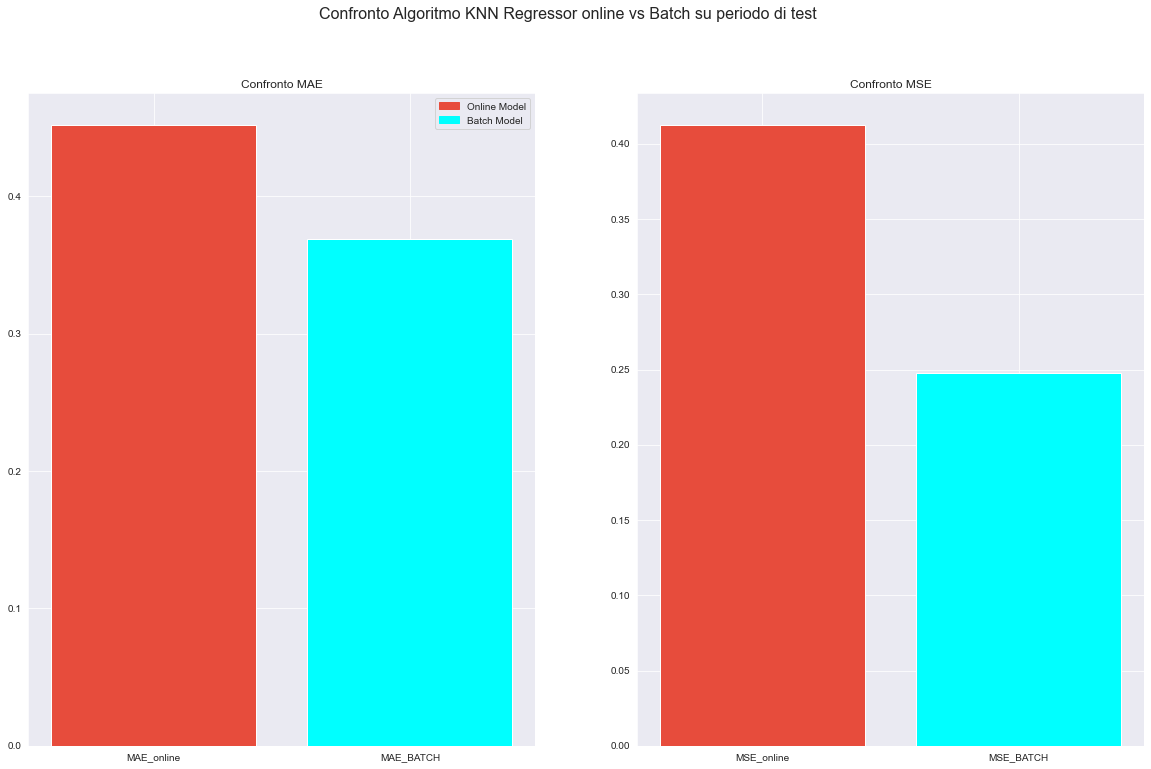

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN Regressor online vs Batch su periodo di test',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_test_knm, y_preds_knnreg[-7877::]),mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_test_knm, y_preds_knnreg[-7877::]),mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])

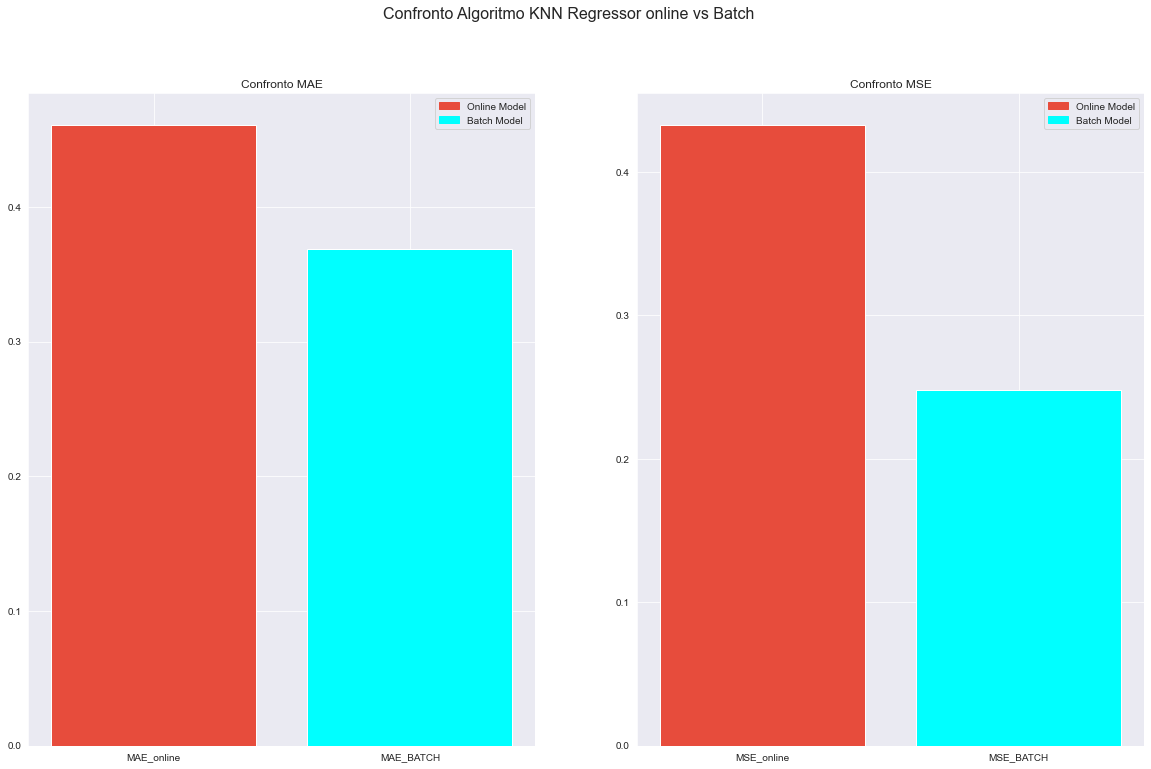

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN Regressor online vs Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_knnreg[-1],mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_knnreg[-1],mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

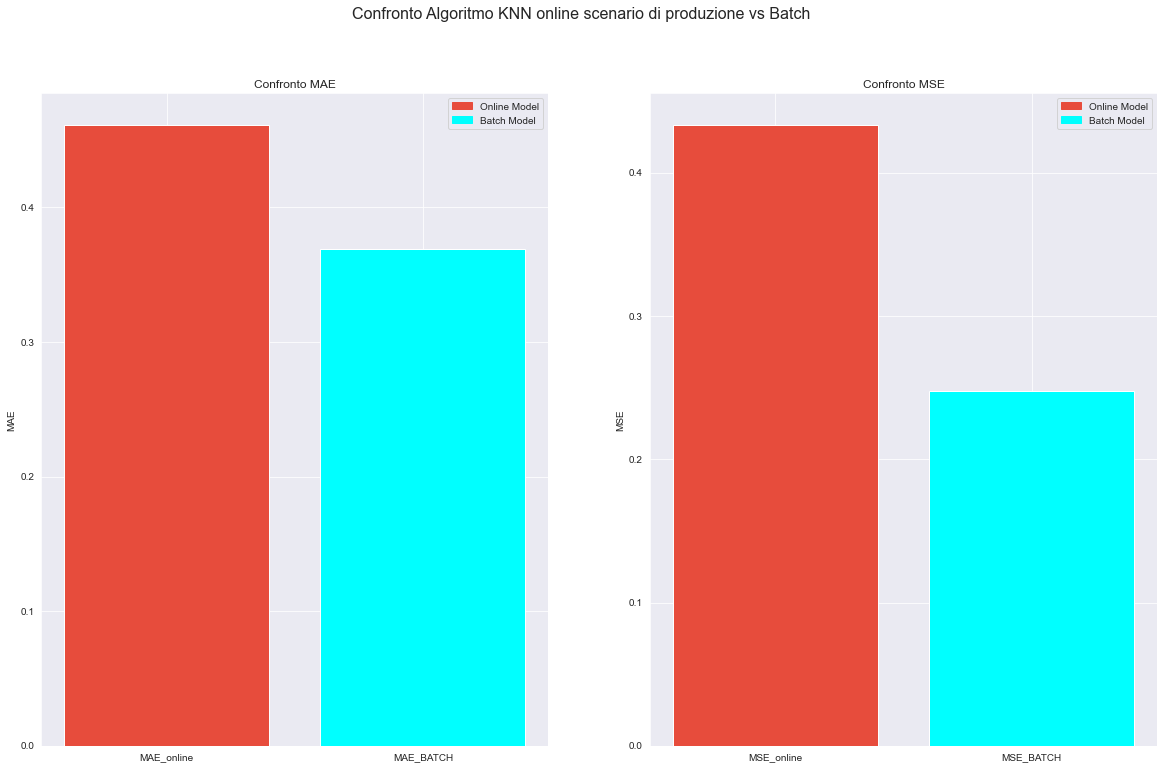

In [19]:
ax2.set_title('Confronto MSE')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN online scenario di produzione vs Batch', fontsize=16)

ax1.bar(height=[0.461543, mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MAE_online', 'MAE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[0.433621, mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MSE_online', 'MSE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

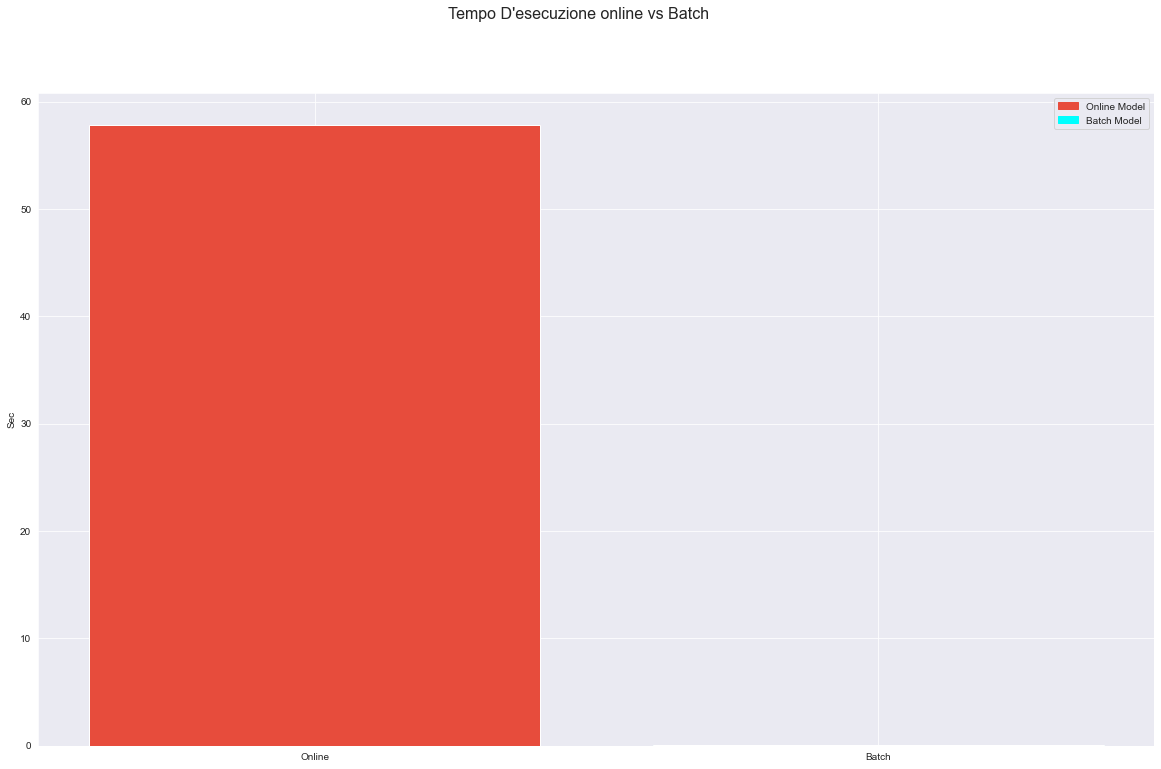

In [20]:
fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[57.86448669433594, 0.0303657054], x=['Online','Batch'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

Text(0.5, 1.0, 'BATCH')

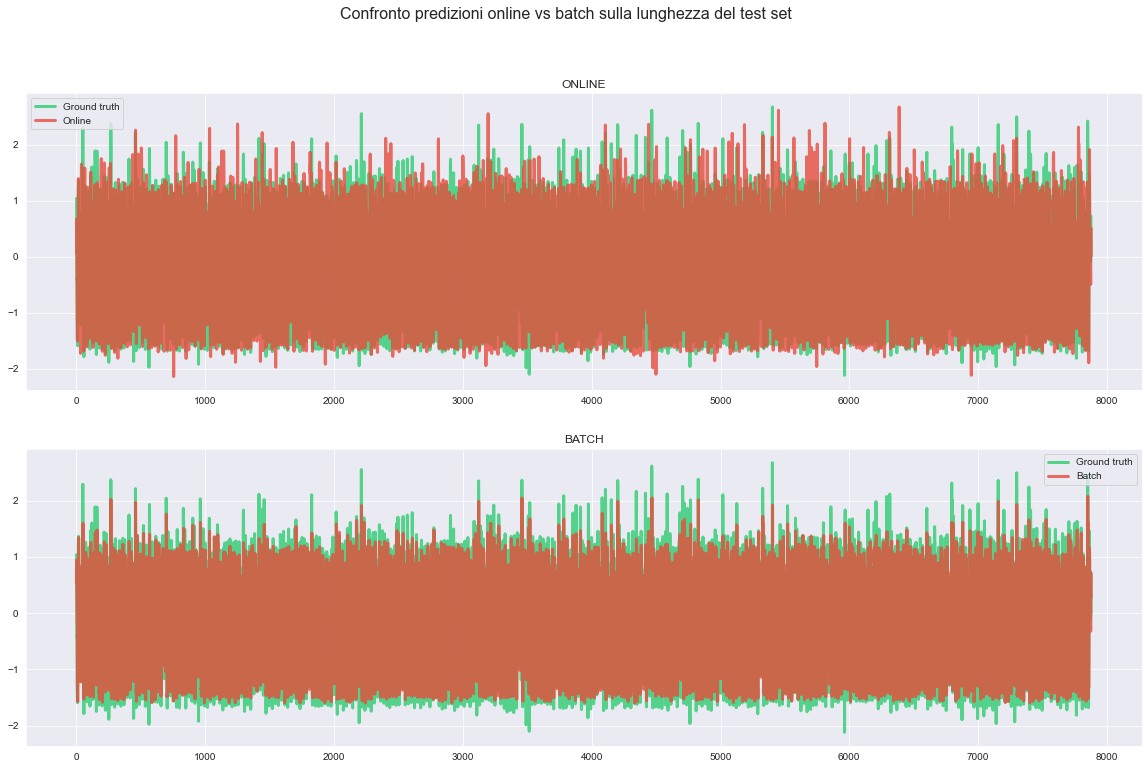

In [21]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot( Y_test_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot( Y_test_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot( y_preds_knnreg[-7877::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot( result_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()
ax1.set_title('ONLINE')
ax2.set_title('BATCH')

## Random Forest Online vs Random Forest Batch


### Random Forest Online


100%|██████████| 26256/26256 [09:37<00:00, 45.48it/s]

Execution time: 577.3353056907654 seconds


Text(0.5, 1.0, 'MSE: 0.260669')

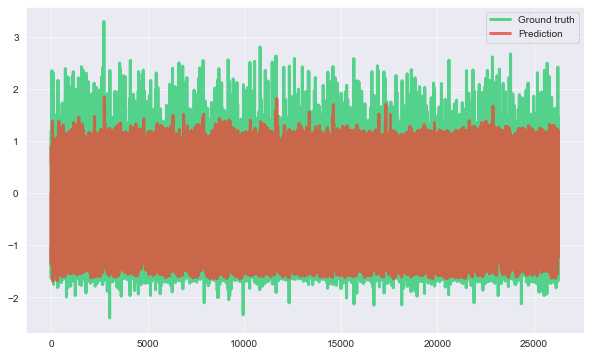

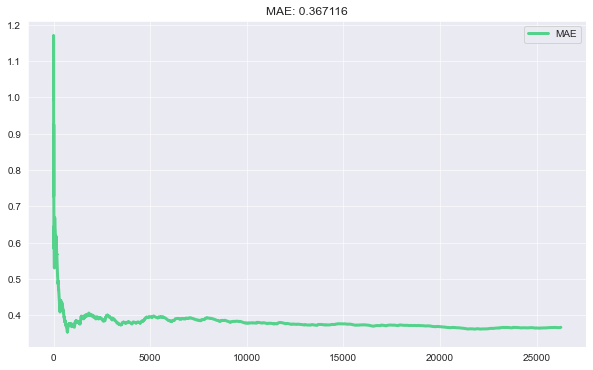

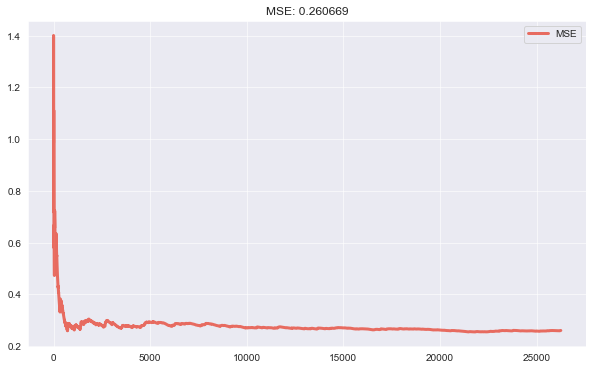

In [22]:
metric_mae_ranFor_on = metrics.MAE()
metric_mse_ranFor_on = metrics.MSE()

dates_ranFor_on = []
y_trues_ranFor_on = []
y_preds_ranFor_on = []
metrics_MAE_ranFor_on = []
metrics_MSE_ranFor_on = []

X_y = initial_iter_italy()


model = compose.Select( 'hour')
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor(metric=metrics.MAE())

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #26256
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_ranFor_on.update(y, y_pred)
       metric_mse_ranFor_on.update(y, y_pred)
       metrics_MAE_ranFor_on.append(metric_mae_ranFor_on.get())
       metrics_MSE_ranFor_on.append(metric_mse_ranFor_on.get())

       # Store the true value and the prediction
       dates_ranFor_on.append(i)
       y_trues_ranFor_on.append(y)
       y_preds_ranFor_on.append(y_pred)


et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, y_trues_ranFor_on, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_ranFor_on, y_preds_ranFor_on, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, metrics_MAE_ranFor_on, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_ranFor_on)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, metrics_MSE_ranFor_on, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_ranFor_on)

In [59]:
X_y = initial_iter_italy()


model = compose.Select( 'hour')
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor(metric=metrics.MAE())

evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MAE(),
       delay=3,
       print_every=3000
)

[3,000] MAE: 0.404106
[6,000] MAE: 0.393424
[9,000] MAE: 0.389166
[12,000] MAE: 0.381795
[15,000] MAE: 0.379796
[18,000] MAE: 0.375994
[21,000] MAE: 0.368404
[24,000] MAE: 0.368191


MAE: 0.36761

In [61]:
X_y = initial_iter_italy()


model = compose.Select( 'hour')
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor(metric=metrics.MAE())

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       delay=3,
       print_every=3000
)

[3,000] MSE: 0.306781
[6,000] MSE: 0.291076
[9,000] MSE: 0.284466
[12,000] MSE: 0.276047
[15,000] MSE: 0.276963
[18,000] MSE: 0.274095
[21,000] MSE: 0.263971
[24,000] MSE: 0.264418


MSE: 0.263683

### Random Forest Batch


In [63]:
len(X_RF)

26255

In [23]:
X_RF = dati_complete_italy[['PowerDemandValue', 'hour']].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_RF, y_RF = split_sequence(X_RF, 1)

X_RF = np.array(X_RF).reshape((26255,2))

y_RF = np.array(y_RF)
y_RF = y_RF[:, [0]]



In [24]:
X_train_RF, X_test_RF, Y_train_RF, Y_test_RF = train_test_split(X_RF, y_RF, random_state=1, train_size=0.7, shuffle=False)

In [25]:
# get the start time
st = time.time()

regr_random_forest = RandomForestRegressor(max_depth=10 , random_state=0).fit(X_train_RF, Y_train_RF)
result_random_forest = regr_random_forest.predict(X_test_RF).reshape(-1,1)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/tmp/ipykernel_37609/972670196.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_random_forest = RandomForestRegressor(max_depth=10 , random_state=0).fit(X_train_RF, Y_train_RF)


Execution time: 1.6267931461334229 seconds


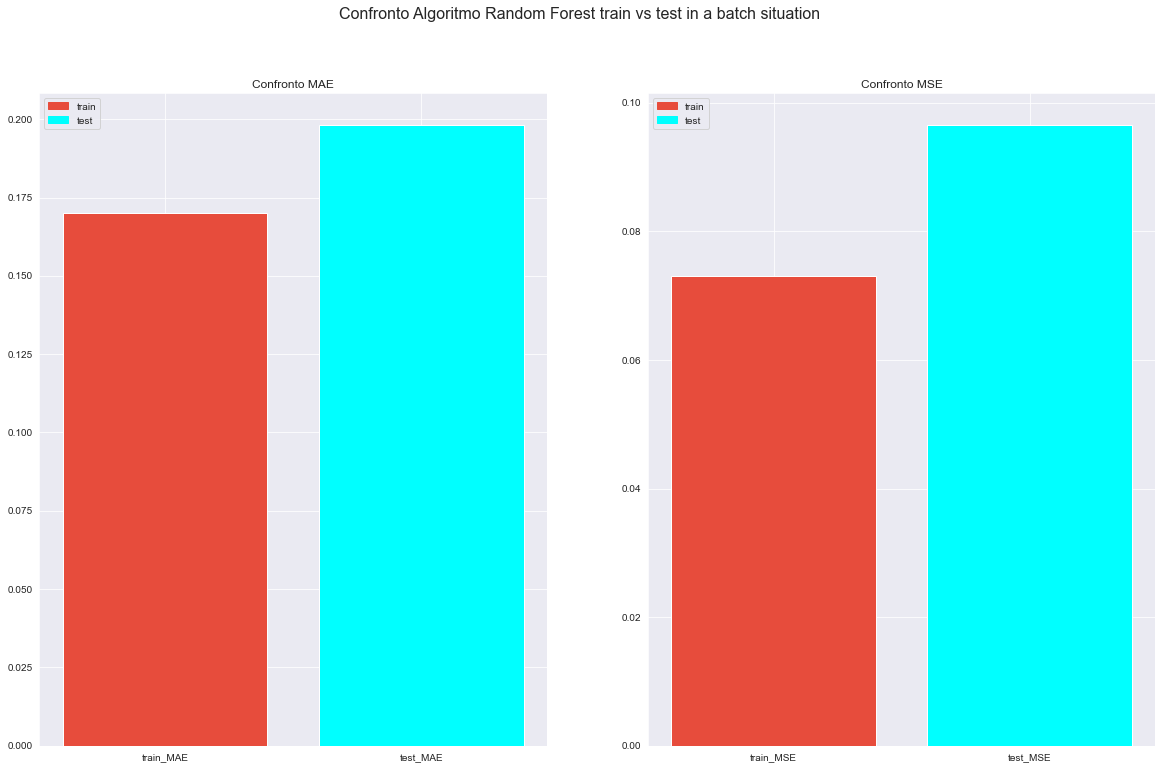

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest train vs test in a batch situation',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_train_RF, regr_random_forest.predict(X_train_RF)),mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['train_MAE','test_MAE'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_train_RF, regr_random_forest.predict(X_train_RF)),mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['train_MSE','test_MSE'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='train')
cyan_patch= mpatches.Patch(color='cyan', label='test')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

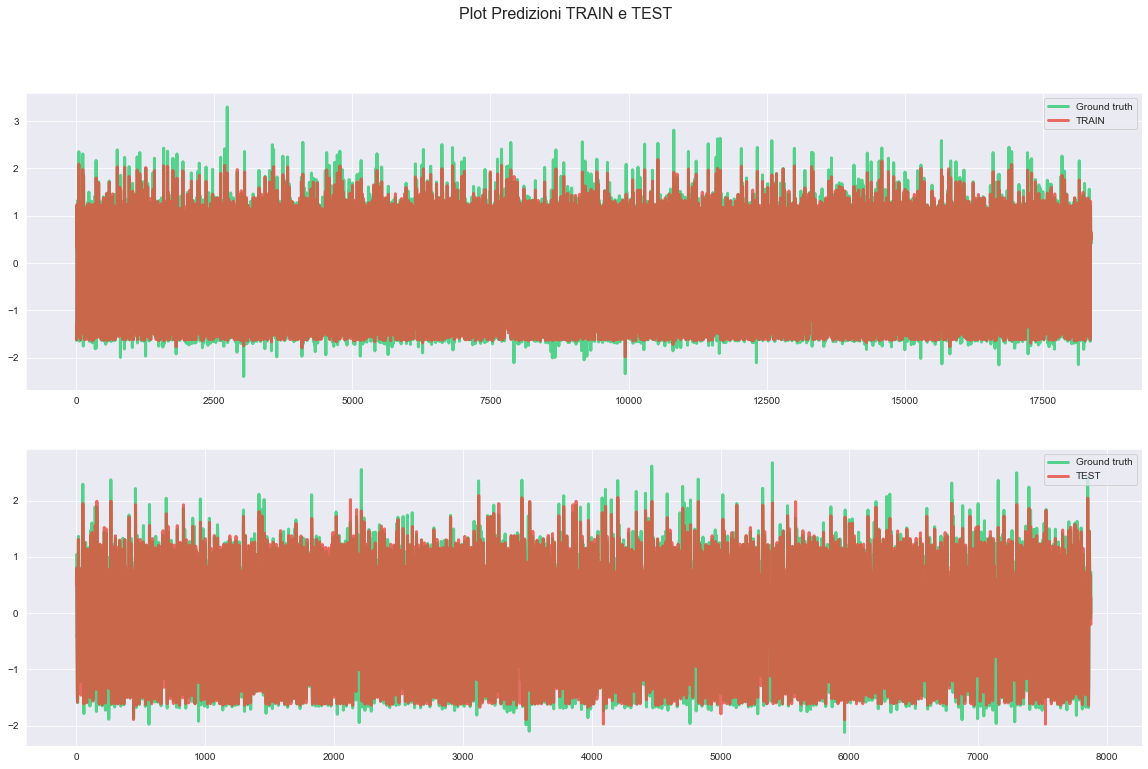

In [27]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Plot Predizioni TRAIN e TEST',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_train_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(regr_random_forest.predict(X_train_RF), lw=3, color='#e74c3c', alpha=0.8, label='TRAIN')
ax2.plot(regr_random_forest.predict(X_test_RF), lw=3, color='#e74c3c', alpha=0.8, label='TEST')
ax1.legend()
ax2.legend()

### Confronto Random Forest Batch vs Random Forest Online


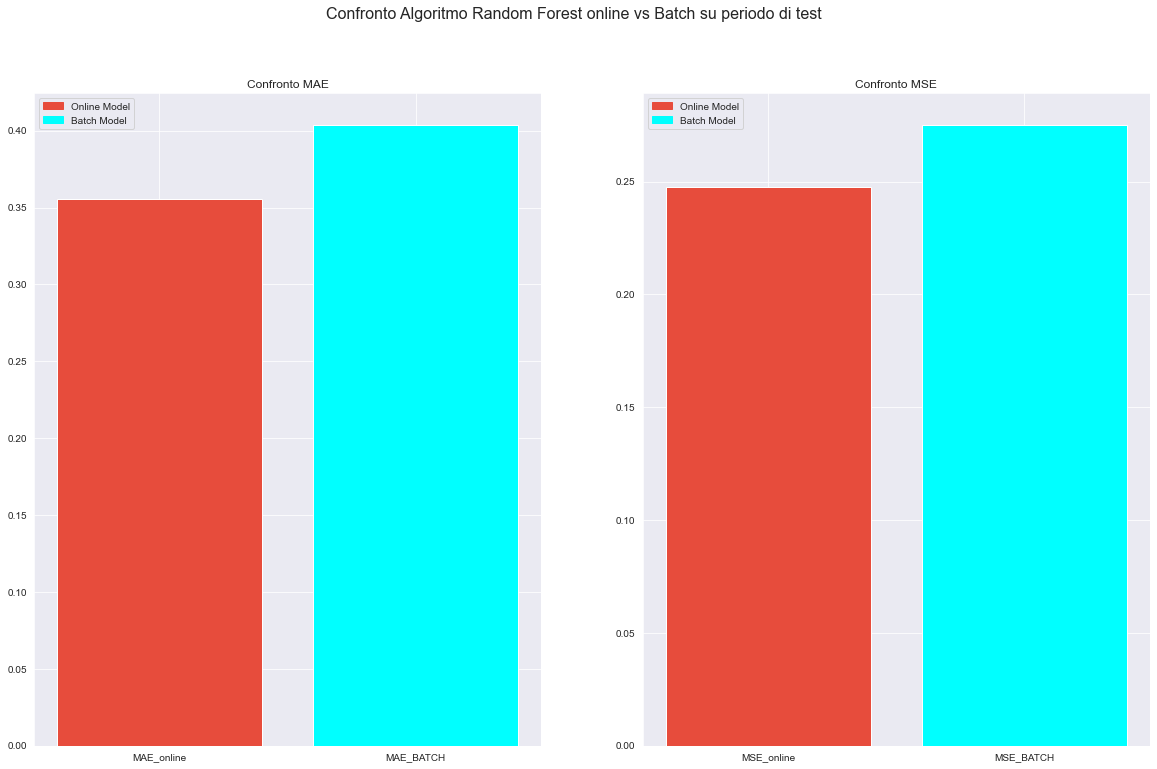

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest online vs Batch su periodo di test',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_test_RF, y_preds_ranFor_on[-7877::]),mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_test_RF, y_preds_ranFor_on[-7877::]),mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

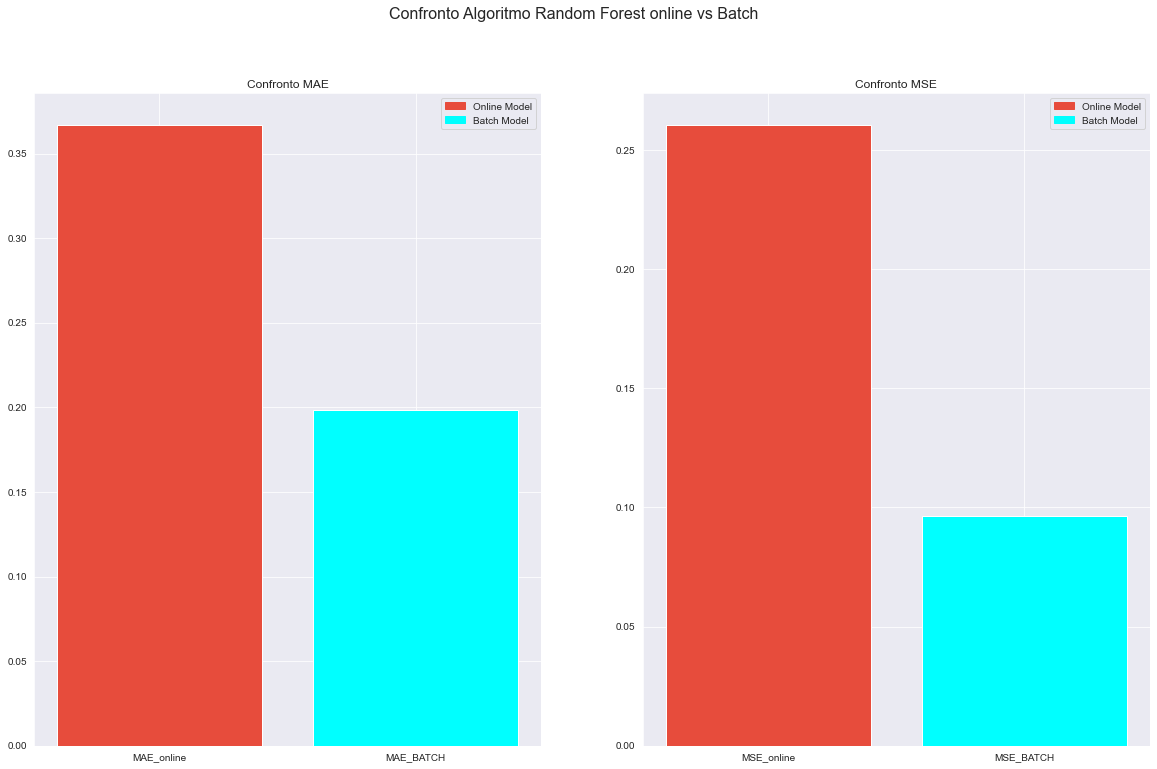

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest online vs Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_ranFor_on[-1],mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_ranFor_on[-1],mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

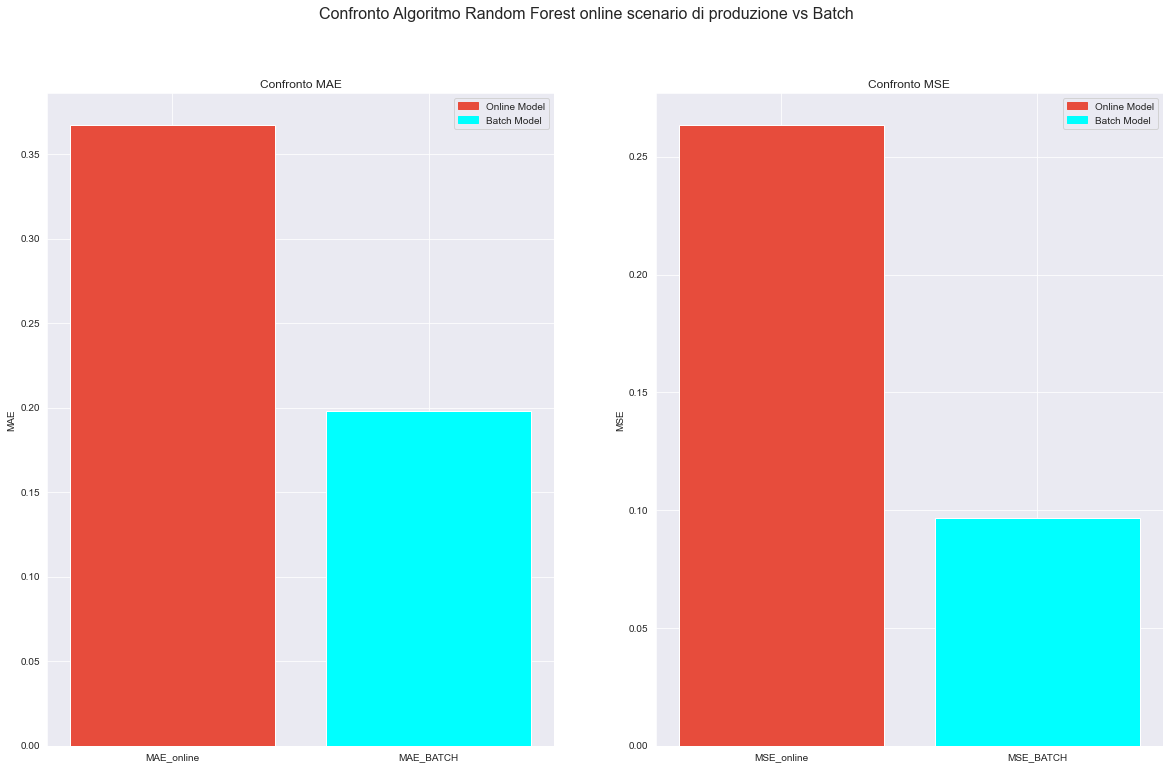

In [30]:
ax2.set_title('Confronto MSE')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest online scenario di produzione vs Batch', fontsize=16)

ax1.bar(height=[0.36761, mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MAE_online', 'MAE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[0.263683, mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MSE_online', 'MSE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

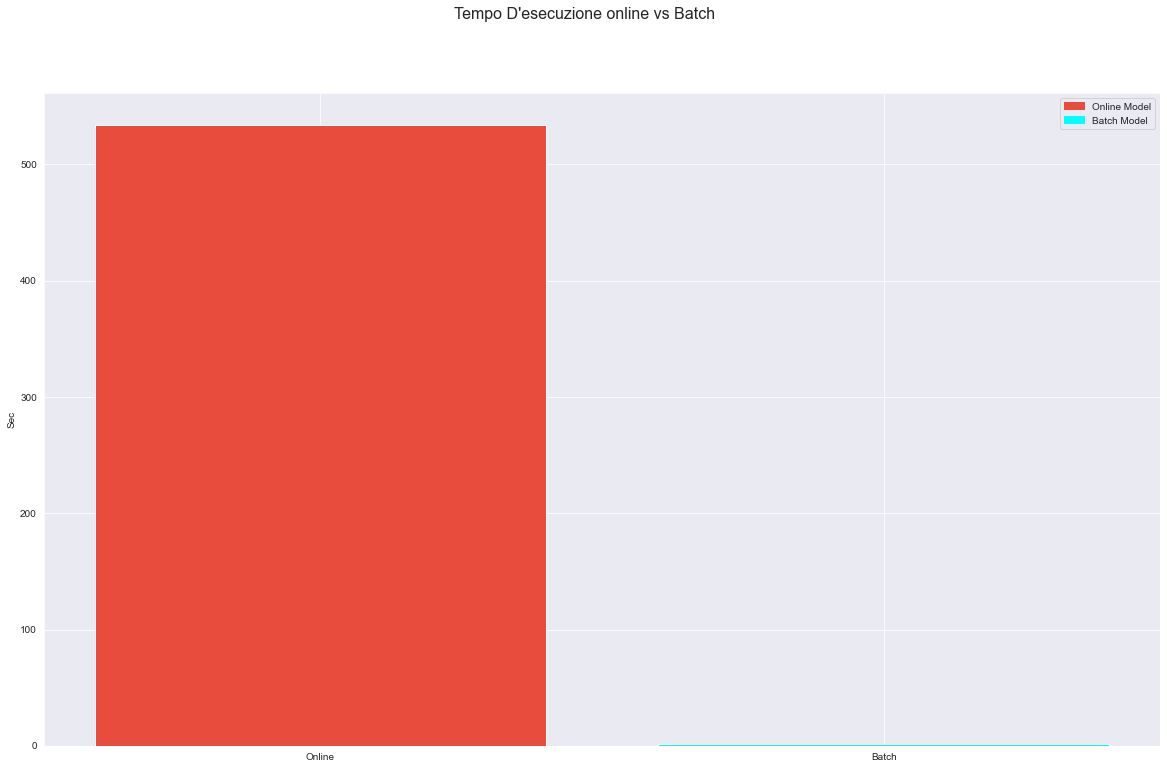

In [31]:
fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[534.30783462, 1.684919], x=['Online','Batch'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

Text(0.5, 1.0, 'BATCH')

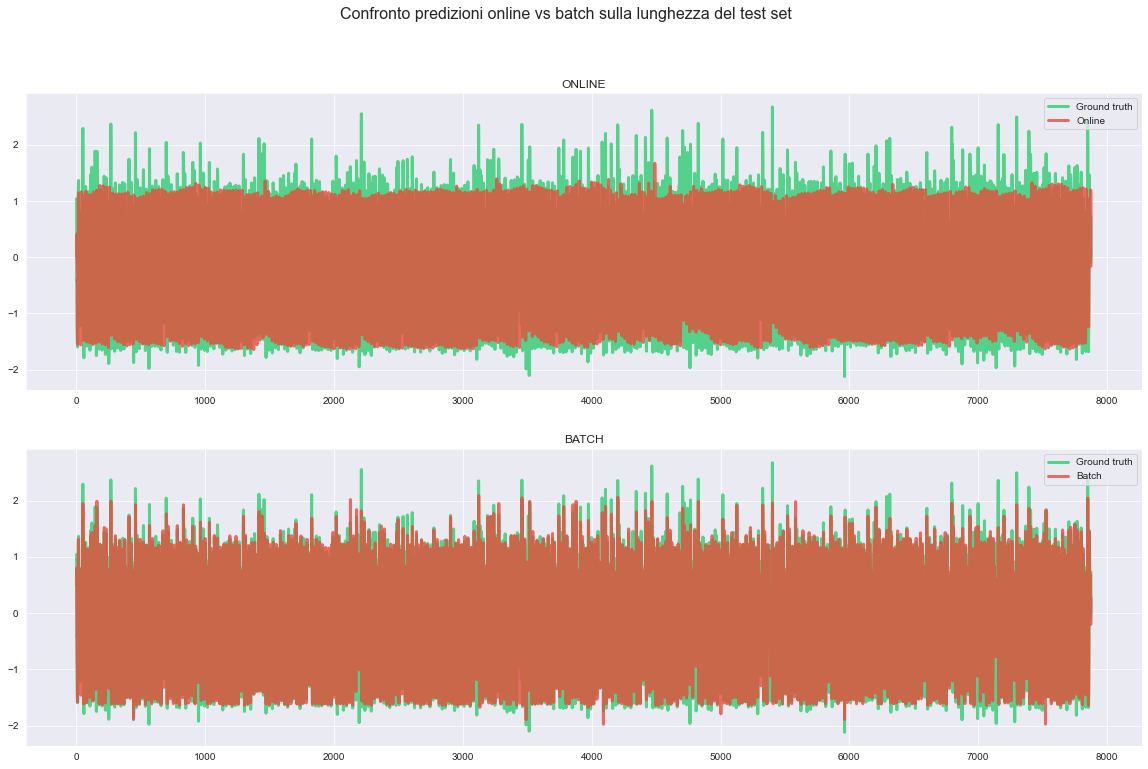

In [32]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_test_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(y_preds_ranFor_on[-7877::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(result_random_forest, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()
ax1.set_title('ONLINE')
ax2.set_title('BATCH')

## Decision Tree Online vs Decision Tree Batch


### Decision Tree Online


In [105]:
next(initial_iter_italy()
)

({'': '0', 'Count_days': 0, 'hour': 0}, -0.99300935)

100%|██████████| 26256/26256 [00:51<00:00, 512.50it/s]


Execution time: 51.23368740081787 seconds


Text(0.5, 1.0, 'MSE: 0.948252')

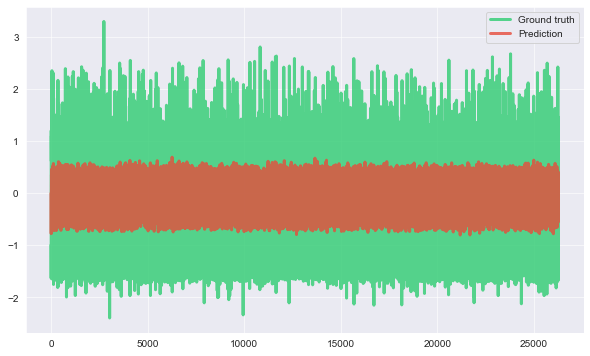

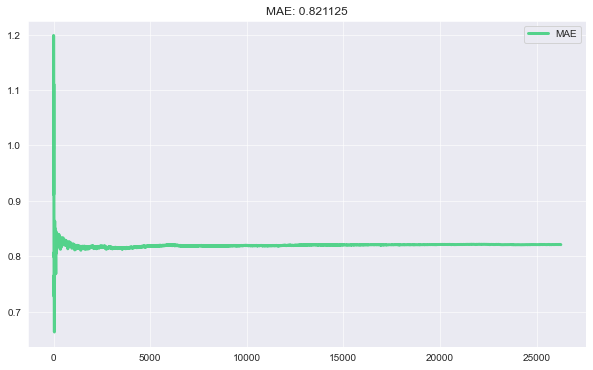

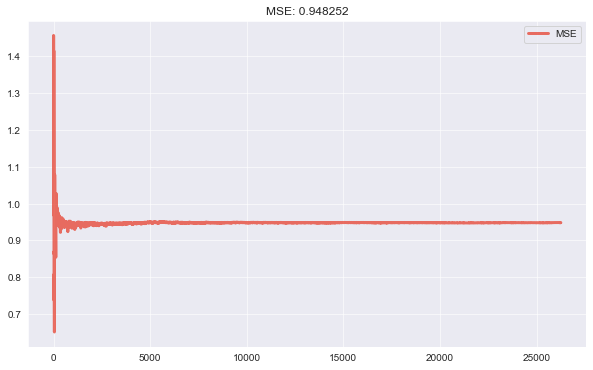

In [33]:
metric_mae_dec_tree = metrics.MAE()
metric_mse_dec_tree = metrics.MSE()

dates_dec_tree = []
y_trues_dec_tree = []
y_preds_dec_tree = []
metrics_MAE_dec_tree = []
metrics_MSE_dec_tree = []

X_y = initial_iter_italy()

base_model = tree.HoeffdingTreeRegressor(grace_period=50)
model = compose.Select()
model |= ensemble.SRPRegressor(
       model=base_model,
       training_method='subspaces',
       n_models=10
)

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #26256
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_dec_tree.update(y, y_pred)
       metric_mse_dec_tree.update(y, y_pred)
       metrics_MAE_dec_tree.append(metric_mae_dec_tree.get())
       metrics_MSE_dec_tree.append(metric_mse_dec_tree.get())

       # Store the true value and the prediction
       dates_dec_tree.append(i)
       y_trues_dec_tree.append(y)
       y_preds_dec_tree.append(y_pred)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, y_trues_dec_tree, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_dec_tree, y_preds_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, metrics_MAE_dec_tree, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_dec_tree)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, metrics_MSE_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_dec_tree)

In [101]:
X_y = initial_iter_italy()

base_model = tree.HoeffdingTreeRegressor(grace_period=50)
model = compose.Select()
model |= ensemble.SRPRegressor(
       model=base_model,
       training_method='patches',
       n_models=10
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       delay=3,
       print_every=3000
)

[3,000] MAE: 0.964344
[6,000] MAE: 0.968485
[9,000] MAE: 0.967052
[12,000] MAE: 0.967536
[15,000] MAE: 0.968332
[18,000] MAE: 0.969184
[21,000] MAE: 0.969926
[24,000] MAE: 0.969286


MAE: 0.969234

In [102]:
X_y = initial_iter_italy()

base_model = tree.HoeffdingTreeRegressor(grace_period=50)
model = compose.Select()
model |= ensemble.SRPRegressor(
       model=base_model,
       training_method='patches',
       n_models=10
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       delay=3,
       print_every=3000
)

[3,000] MSE: 1.303536
[6,000] MSE: 1.306769
[9,000] MSE: 1.308264
[12,000] MSE: 1.307526
[15,000] MSE: 1.308553
[18,000] MSE: 1.308315
[21,000] MSE: 1.30885
[24,000] MSE: 1.309057


MSE: 1.308428

### Decision Tree Batch


In [34]:
X_DT = dati_complete_italy['PowerDemandValue'].to_numpy()


def split_sequence(sequence, n_steps):
       X, y = list(), list()
       for i in range(len(sequence)):
              # find the end of this pattern
              end_ix = i + n_steps
              # check if we are beyond the sequence
              if end_ix > len(sequence) - 1:
                     break
              # gather input and output parts of the pattern
              seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
              X.append(seq_x)
              y.append(seq_y)
       return X, y


# split into samples
X_DT, y_DT = split_sequence(X_DT, 1)

X_train_DT, X_test_DT, Y_train_DT, Y_test_DT = train_test_split(X_DT, y_DT, random_state=1, train_size=0.7, shuffle=False)

# get the start time
st = time.time()

regressor_dec_tree = DecisionTreeRegressor(random_state=0, max_depth=7).fit(X_train_DT, Y_train_DT)

result_dec_tree = regressor_dec_tree.predict(X_test_DT)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.04988288879394531 seconds


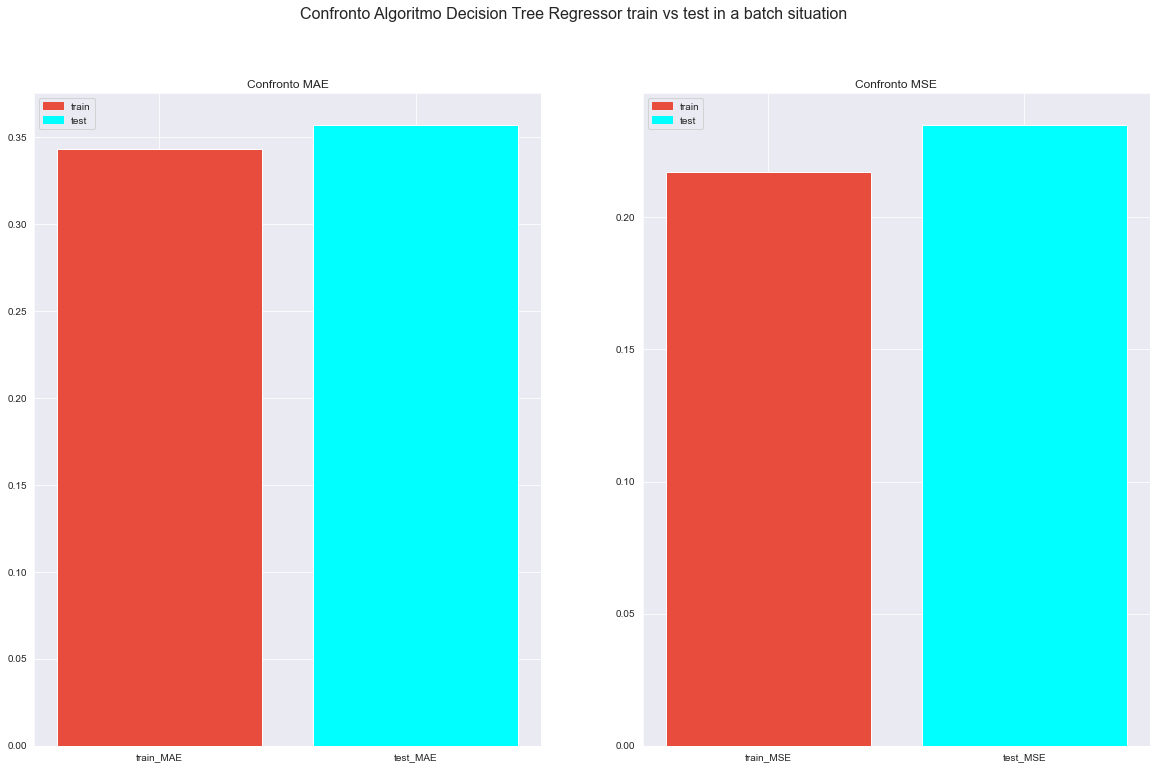

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Decision Tree Regressor train vs test in a batch situation',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_train_DT, regressor_dec_tree.predict(X_train_DT)),mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['train_MAE','test_MAE'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_train_DT, regressor_dec_tree.predict(X_train_DT)),mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['train_MSE','test_MSE'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='train')
cyan_patch= mpatches.Patch(color='cyan', label='test')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

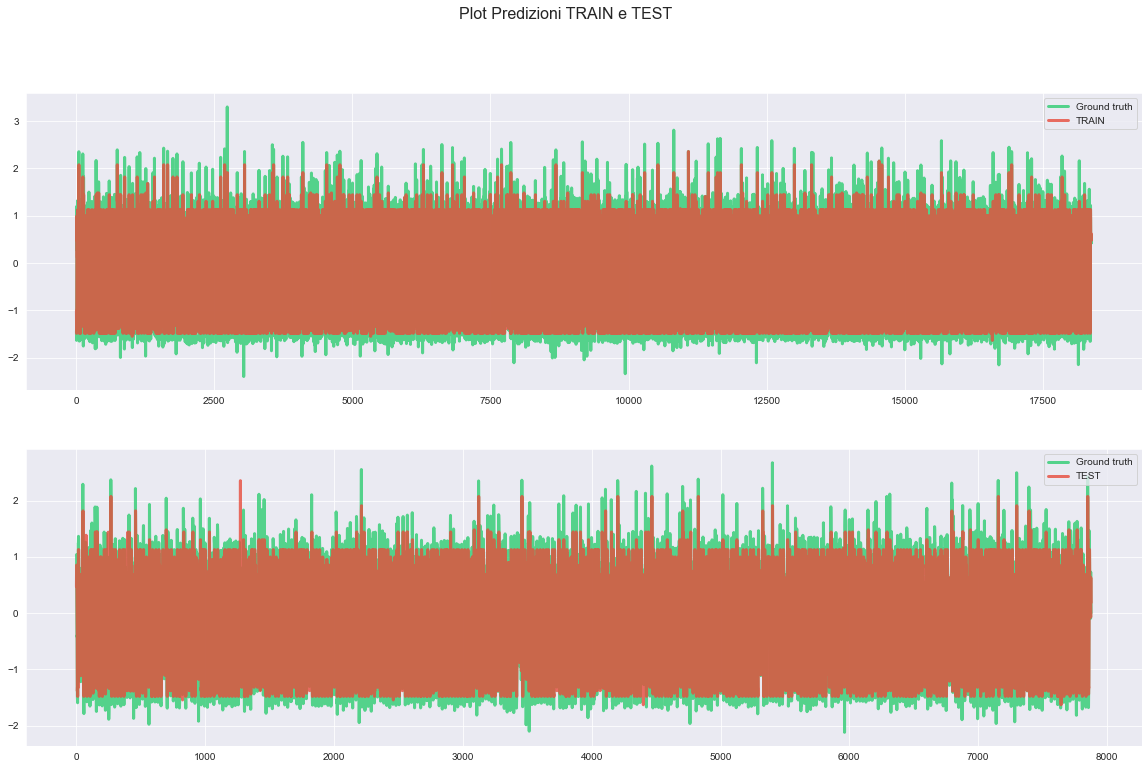

In [37]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Plot Predizioni TRAIN e TEST',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_train_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(regressor_dec_tree.predict(X_train_DT), lw=3, color='#e74c3c', alpha=0.8, label='TRAIN')
ax2.plot(regressor_dec_tree.predict(X_test_DT), lw=3, color='#e74c3c', alpha=0.8, label='TEST')
ax1.legend()
ax2.legend()

### Confronto Decision Tree Batch vs Decision Tree Online

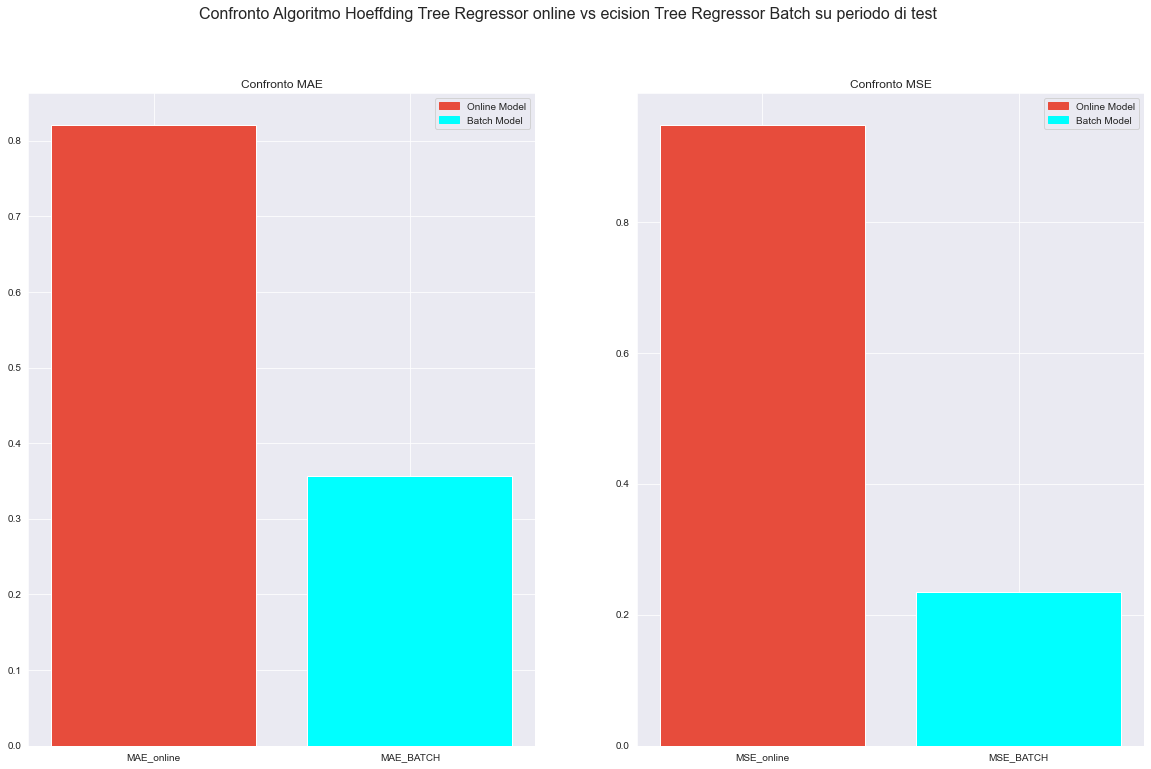

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Hoeffding Tree Regressor online vs ecision Tree Regressor Batch su periodo di test',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_test_DT, y_preds_dec_tree[-7877::]),mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_test_DT, y_preds_dec_tree[-7877::]),mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

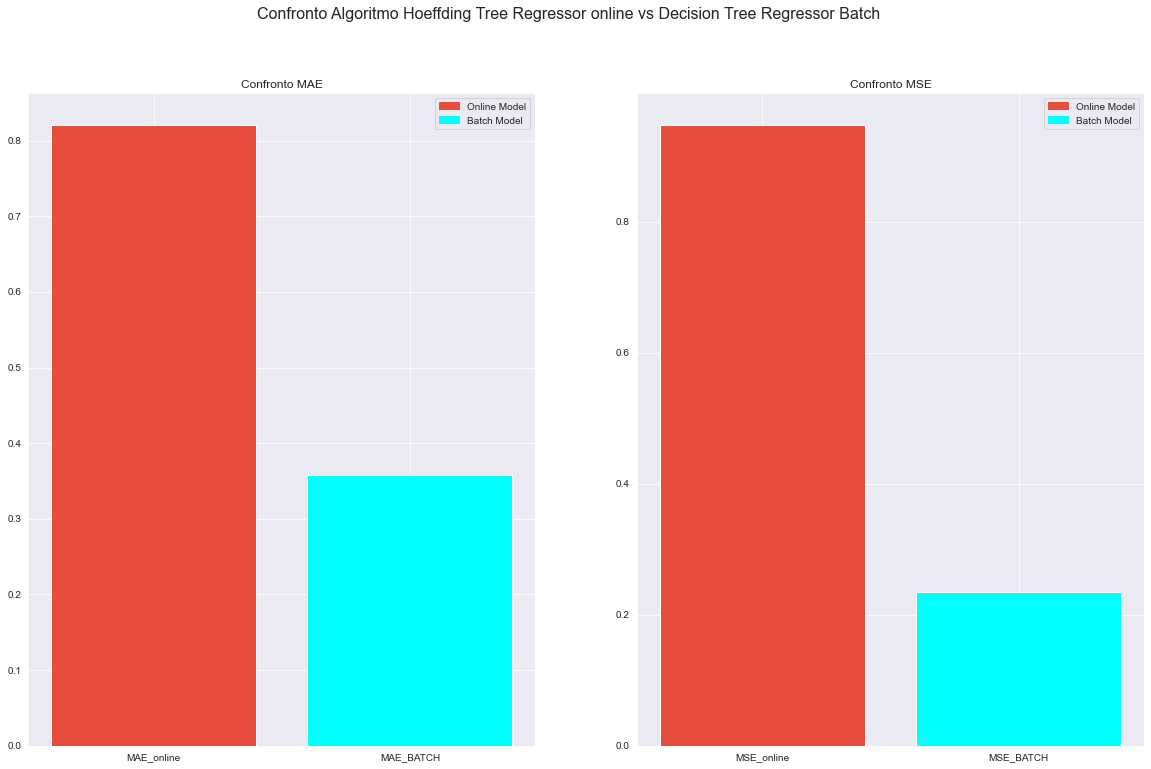

In [39]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Hoeffding Tree Regressor online vs Decision Tree Regressor Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_dec_tree[-1],mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_dec_tree[-1],mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

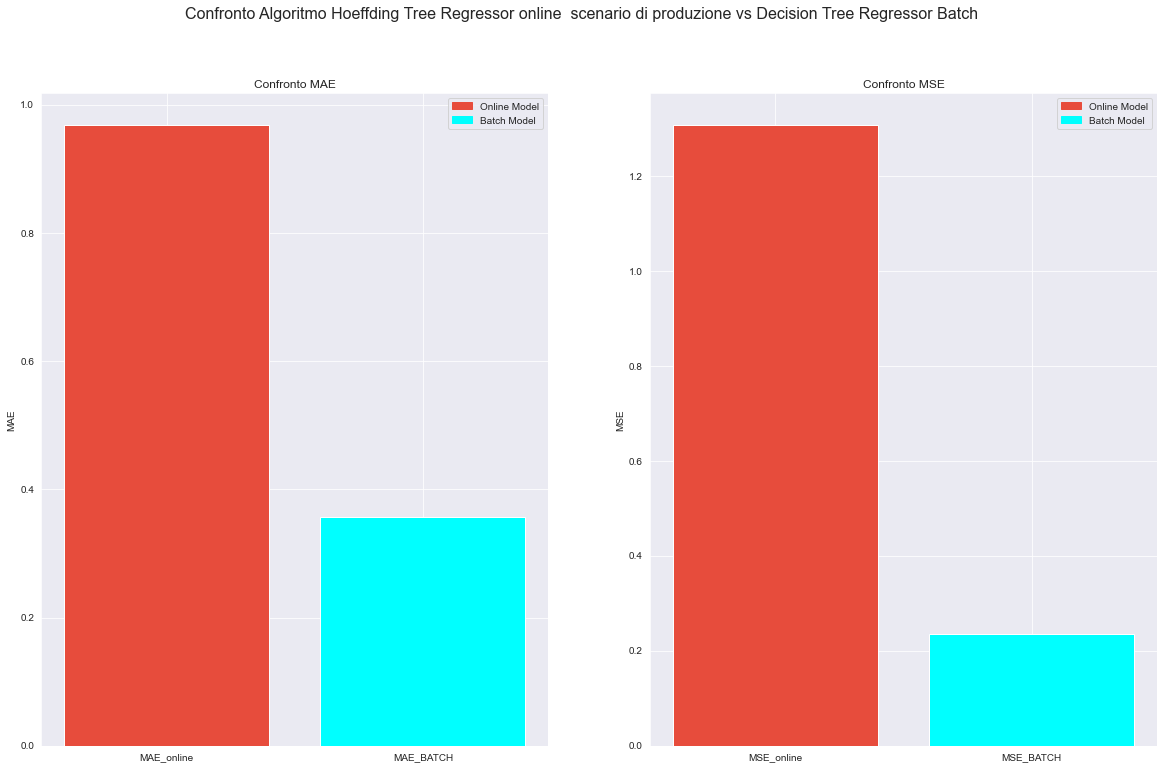

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Hoeffding Tree Regressor online  scenario di produzione vs Decision Tree Regressor Batch',  fontsize=16)

ax1.bar(height=[0.969234,mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[1.308428,mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

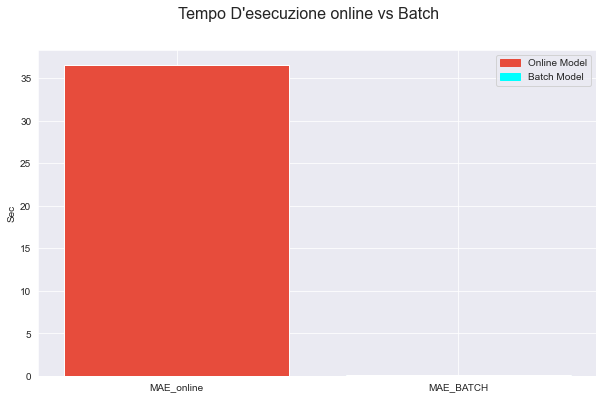

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[36.50877,0.0613856], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

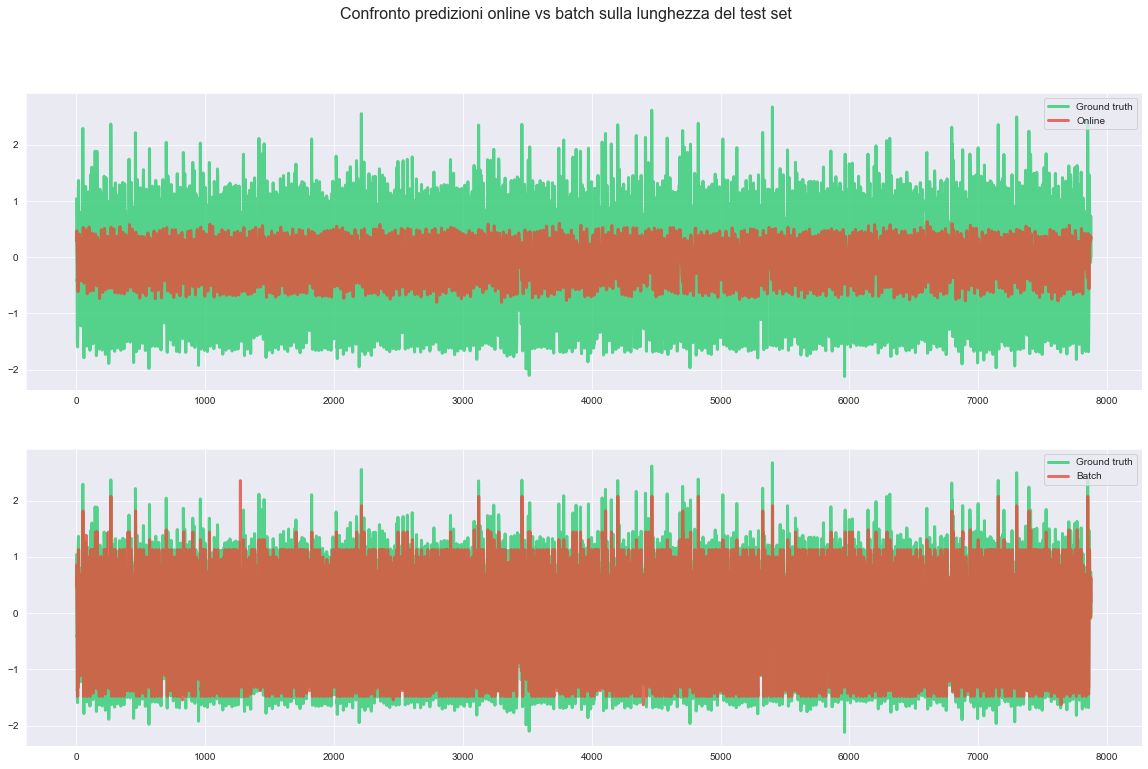

In [42]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(y_preds_dec_tree[-7877::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(result_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()

## Confronto Totale

Text(0.5, 1.0, 'Confronto MSE')

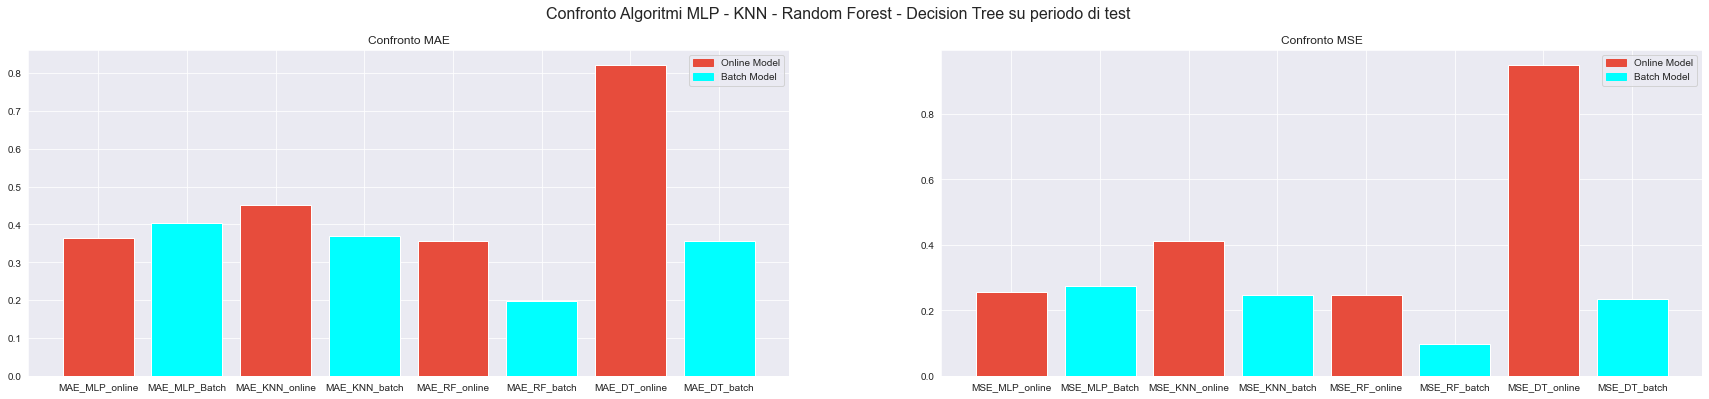

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 6))

fig.suptitle('Confronto Algoritmi MLP - KNN - Random Forest - Decision Tree su periodo di test',  fontsize=16)

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')


ax1.bar(height=[
       mean_absolute_error(Y_test_mlp, y_preds_ml_online[-7877::]),mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       mean_absolute_error(Y_test_knm, y_preds_knnreg[-7877::]), mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
       mean_absolute_error(Y_test_RF, y_preds_ranFor_on[-7877::]),mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       mean_absolute_error(Y_test_DT, y_preds_dec_tree[-7877::]), mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MAE_MLP_online','MAE_MLP_Batch','MAE_KNN_online','MAE_KNN_batch','MAE_RF_online','MAE_RF_batch','MAE_DT_online','MAE_DT_batch'],
        color=['#e74c3c', 'cyan'])
ax1.legend(handles=[red_patch, cyan_patch])
ax1.set_title('Confronto MAE')
ax2.bar(height=[
       mean_squared_error(Y_test_mlp, y_preds_ml_online[-7877::]),mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       mean_squared_error(Y_test_knm, y_preds_knnreg[-7877::]), mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
       mean_squared_error(Y_test_RF, y_preds_ranFor_on[-7877::]),mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       mean_squared_error(Y_test_DT, y_preds_dec_tree[-7877::]), mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MSE_MLP_online','MSE_MLP_Batch','MSE_KNN_online','MSE_KNN_batch','MSE_RF_online','MSE_RF_batch','MSE_DT_online','MSE_DT_batch'],
       color=['#e74c3c', 'cyan'])
ax2.legend(handles=[red_patch, cyan_patch])
ax2.set_title('Confronto MSE')

Text(0.5, 1.0, 'Confronto MSE')

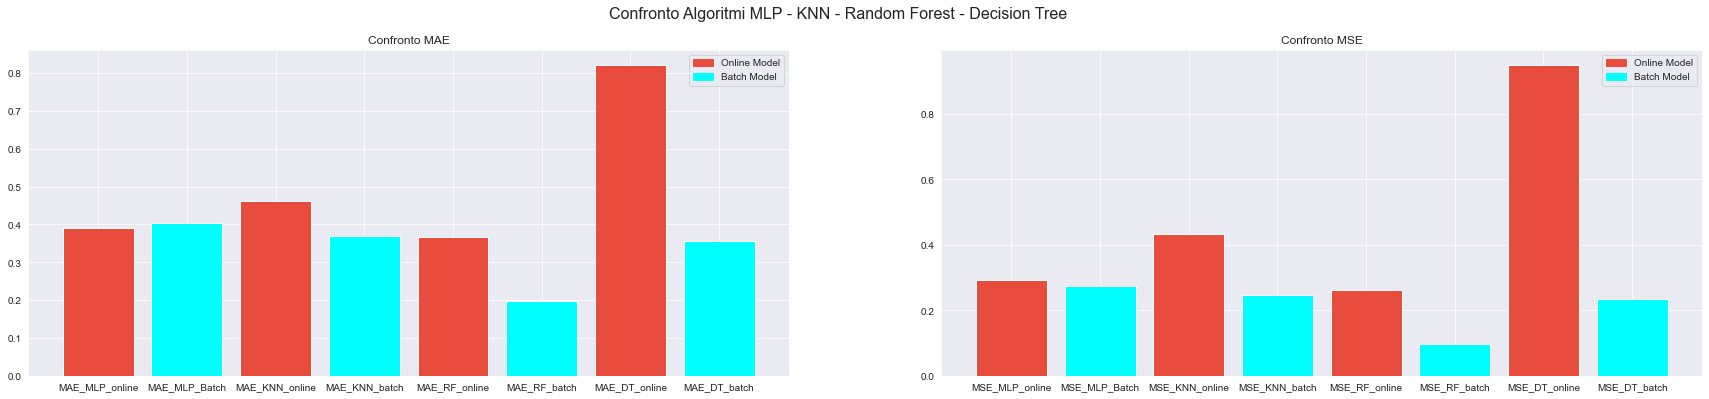

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 6))

fig.suptitle('Confronto Algoritmi MLP - KNN - Random Forest - Decision Tree',  fontsize=16)

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')


ax1.bar(height=[
       metrics_MAE_ml_online[-1],mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       metrics_MAE_knnreg[-1], mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
       metrics_MAE_ranFor_on[-1],mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       metrics_MAE_dec_tree[-1], mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MAE_MLP_online','MAE_MLP_Batch','MAE_KNN_online','MAE_KNN_batch','MAE_RF_online','MAE_RF_batch','MAE_DT_online','MAE_DT_batch'],
        color=['#e74c3c', 'cyan'])
ax1.legend(handles=[red_patch, cyan_patch])
ax1.set_title('Confronto MAE')
ax2.bar(height=[
       metrics_MSE_ml_online[-1],mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       metrics_MSE_knnreg[-1], mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
       metrics_MSE_ranFor_on[-1],mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       metrics_MSE_dec_tree[-1], mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MSE_MLP_online','MSE_MLP_Batch','MSE_KNN_online','MSE_KNN_batch','MSE_RF_online','MSE_RF_batch','MSE_DT_online','MSE_DT_batch'],
       color=['#e74c3c', 'cyan'])
ax2.legend(handles=[red_patch, cyan_patch])
ax2.set_title('Confronto MSE')

Text(0.5, 1.0, 'Confronto MSE')

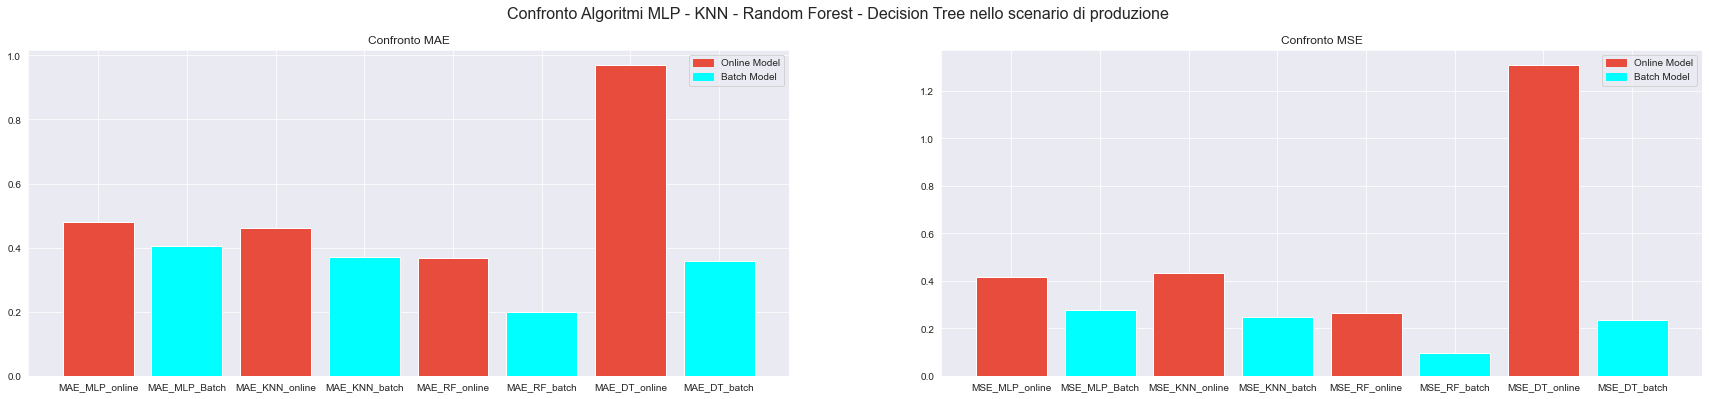

In [45]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 6))

fig.suptitle('Confronto Algoritmi MLP - KNN - Random Forest - Decision Tree nello scenario di produzione',  fontsize=16)

ax1.bar(height=[
       0.480439,mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       0.461543, mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
       0.36761,mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       0.969234, mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MAE_MLP_online','MAE_MLP_Batch','MAE_KNN_online','MAE_KNN_batch','MAE_RF_online','MAE_RF_batch','MAE_DT_online','MAE_DT_batch'],
        color=['#e74c3c', 'cyan'],
       )
red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax1.set_title('Confronto MAE')
ax2.bar(height=[
       0.415938,mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       0.433621, mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
       0.263683,mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       1.308428, mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MSE_MLP_online','MSE_MLP_Batch','MSE_KNN_online','MSE_KNN_batch','MSE_RF_online','MSE_RF_batch','MSE_DT_online','MSE_DT_batch'],
       color=['#e74c3c', 'cyan'])
ax2.legend(handles=[red_patch, cyan_patch])
ax2.set_title('Confronto MSE')




Text(0, 0.5, 'Sec')

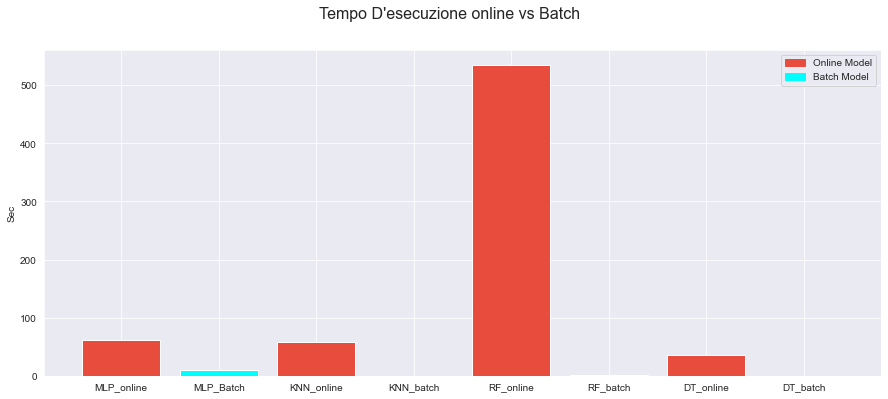

In [46]:
fig, ax = plt.subplots(figsize=(15, 6))

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(
       height=[62.4307641,9.591705799, 57.864486694, 0.0303657054, 534.30783462, 1.6849195957, 36.50877380, 0.061385631],
       x=['MLP_online','MLP_Batch','KNN_online','KNN_batch','RF_online','RF_batch','DT_online','DT_batch'],
       color=['#e74c3c', 'cyan']
)
ax.legend(handles=[red_patch, cyan_patch])
ax.set_ylabel('Sec')

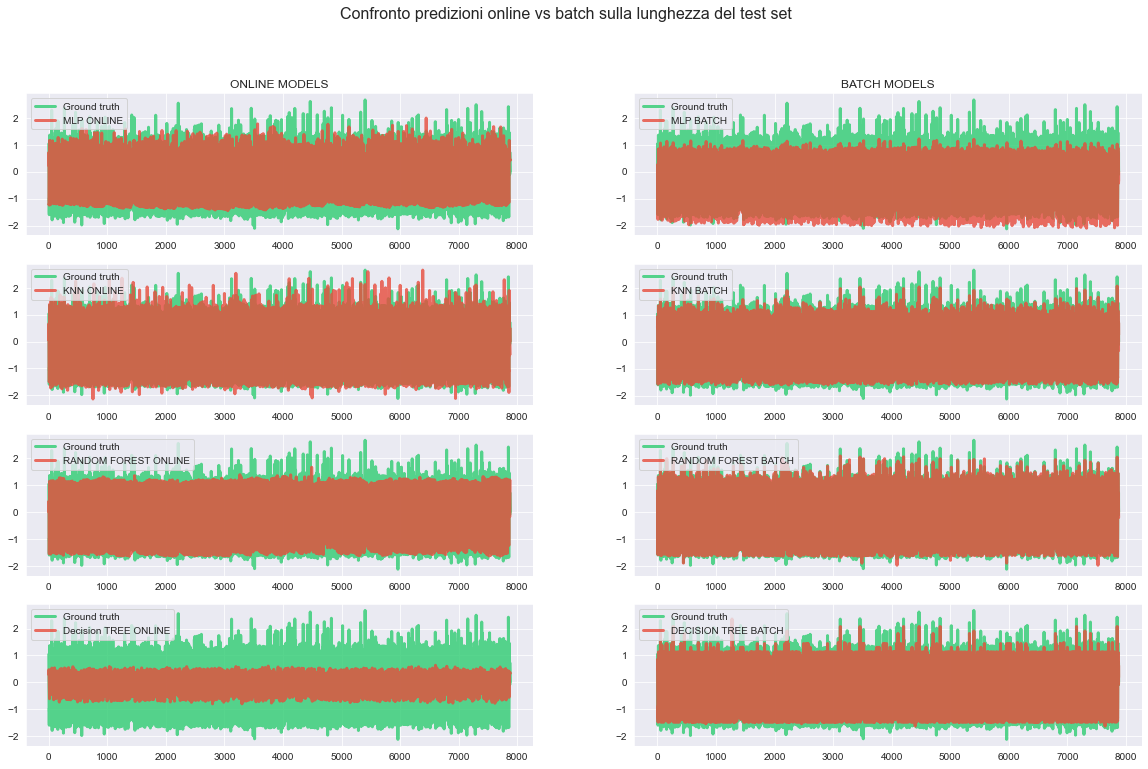

In [48]:
# Plot the results
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax3.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax4.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax5.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax6.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax7.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax8.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')

ax1.plot(y_preds_ml_online[-7877::], lw=3, color='#e74c3c', alpha=0.8, label='MLP ONLINE')

ax2.plot(result_mlpBatch, lw=3, color='#e74c3c', alpha=0.8, label='MLP BATCH')

ax3.plot(y_preds_knnreg[-7877::], lw=3, color='#e74c3c', alpha=0.8, label='KNN ONLINE')

ax4.plot(result_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='KNN BATCH')

ax5.plot(y_preds_ranFor_on[-7877::], lw=3, color='#e74c3c', alpha=0.8, label='RANDOM FOREST ONLINE')

ax6.plot(result_random_forest, lw=3, color='#e74c3c', alpha=0.8, label='RANDOM FOREST BATCH')

ax7.plot(y_preds_dec_tree[-7877::], lw=3, color='#e74c3c', alpha=0.8, label='Decision TREE ONLINE')

ax8.plot(result_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='DECISION TREE BATCH')


ax1.set_title('ONLINE MODELS')
ax2.set_title('BATCH MODELS')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()

## Confronto Batch vs Online - plottare i risultati totali

In [50]:
dati_mae_su_periodo_di_test = {'MAE': [
    mean_absolute_error(Y_test_mlp, y_preds_ml_online[-7877::]),
    mean_absolute_error(Y_test_knm, y_preds_knnreg[-7877::]),
    mean_absolute_error(Y_test_RF, y_preds_ranFor_on[-7877::]),
    mean_absolute_error(Y_test_DT, y_preds_dec_tree[-7877::]),
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

dati_mse_su_periodo_di_test = {'MSE': [
    mean_squared_error(Y_test_mlp, y_preds_ml_online[-7877::]),
    mean_squared_error(Y_test_knm, y_preds_knnreg[-7877::]),
    mean_squared_error(Y_test_RF, y_preds_ranFor_on[-7877::]),
    mean_squared_error(Y_test_DT, y_preds_dec_tree[-7877::]),
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

In [71]:
dati_mae_su_periodo_di_test = pd.DataFrame(dati_mae_su_periodo_di_test)
dati_mse_su_periodo_di_test = pd.DataFrame(dati_mse_su_periodo_di_test)
dati_mae_su_periodo_di_test.to_csv('Risultati_Completi/ItalyPower/dati_mae_su_periodo_di_test')
dati_mse_su_periodo_di_test.to_csv('Risultati_Completi/ItalyPower/dati_mse_su_periodo_di_test')

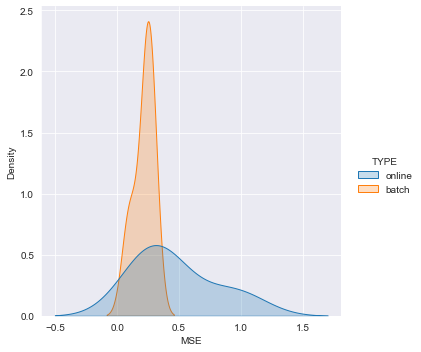

In [73]:
sns.displot(dati_mse_su_periodo_di_test, x='MSE', hue='TYPE',kind="kde", fill=True)

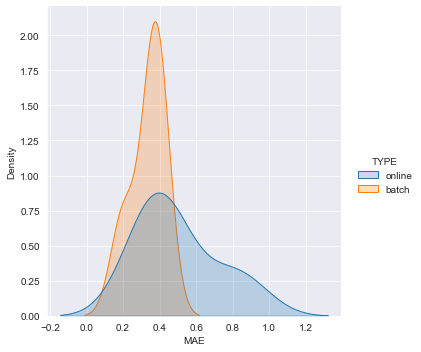

In [53]:
sns.displot(dati_mae_su_periodo_di_test, x='MAE', hue='TYPE',kind="kde", fill=True)

In [54]:
dati_mae = {'MAE': [
    metrics_MAE_ml_online[-1],
    metrics_MAE_knnreg[-1],
    metrics_MAE_ranFor_on[-1],
    metrics_MAE_dec_tree[-1],
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

dati_mse = {'MSE': [
    metrics_MSE_ml_online[-1],
    metrics_MSE_knnreg[-1],
    metrics_MSE_ranFor_on[-1],
    metrics_MSE_dec_tree[-1],
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

In [55]:
dati_mae = pd.DataFrame(dati_mae)
dati_mse = pd.DataFrame(dati_mse)

In [74]:
dati_mae.to_csv('Risultati_Completi/ItalyPower/dati_mae')
dati_mse.to_csv('Risultati_Completi/ItalyPower/dati_mse')

<AxesSubplot:xlabel='MAE', ylabel='TYPE'>

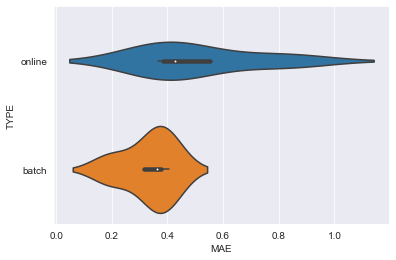

In [56]:
sns.violinplot(x="MAE", y="TYPE", data=dati_mae)

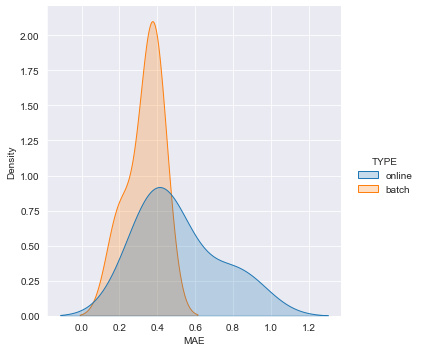

In [57]:
sns.displot(dati_mae, x='MAE', hue='TYPE',kind="kde", fill=True)

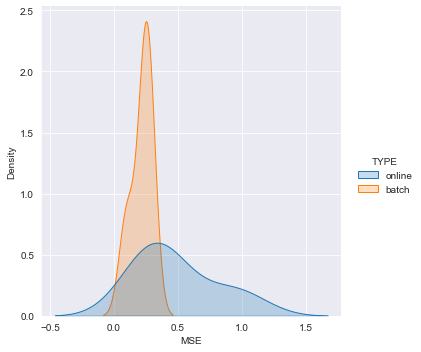

In [58]:
sns.displot(dati_mse, x='MSE', hue='TYPE',kind="kde", fill=True)

In [59]:
dati_mae_production = {'MAE': [
    0.480439,
    0.461543,
    0.36761,
    0.969234,
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

dati_mse_production = {'MSE': [
    0.415938,
    0.433621,
    0.263683,
    1.308428,
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

In [60]:
dati_mae_production = pd.DataFrame(dati_mae_production)
dati_mse_production = pd.DataFrame(dati_mse_production)

In [75]:
dati_mae_production.to_csv('Risultati_Completi/ItalyPower/dati_mae_production')
dati_mse_production.to_csv('Risultati_Completi/ItalyPower/dati_mse_production')

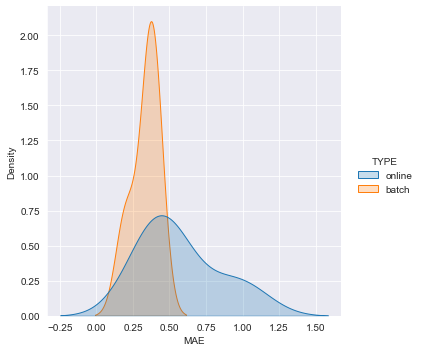

In [61]:
sns.displot(dati_mae_production, x='MAE', hue='TYPE',kind="kde", fill=True)

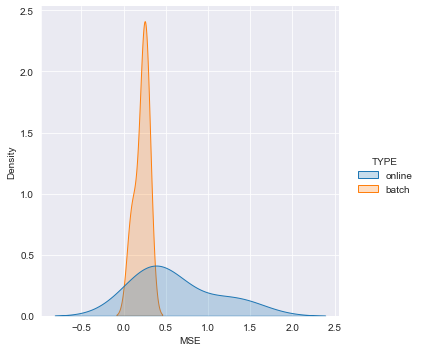

In [62]:
sns.displot(dati_mse_production, x='MSE', hue='TYPE',kind="kde", fill=True)

In [63]:
dati_mae_total = {'MAE': [
    0.480439,
    0.461543,
    0.36761,
    0.969234,
    metrics_MAE_ml_online[-1],
    metrics_MAE_knnreg[-1],
    metrics_MAE_ranFor_on[-1],
    metrics_MAE_dec_tree[-1],
    mean_absolute_error(Y_test_mlp, y_preds_ml_online[-7877::]),
    mean_absolute_error(Y_test_knm, y_preds_knnreg[-7877::]),
    mean_absolute_error(Y_test_RF, y_preds_ranFor_on[-7877::]),
    mean_absolute_error(Y_test_DT, y_preds_dec_tree[-7877::]),
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT)),
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT)),
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
         'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

dati_mse_total = {'MSE': [
    0.415938,
    0.433621,
    0.263683,
    1.308428,
    metrics_MSE_ml_online[-1],
    metrics_MSE_knnreg[-1],
    metrics_MSE_ranFor_on[-1],
    metrics_MSE_dec_tree[-1],
    mean_squared_error(Y_test_mlp, y_preds_ml_online[-7877::]),
    mean_squared_error(Y_test_knm, y_preds_knnreg[-7877::]),
    mean_squared_error(Y_test_RF, y_preds_ranFor_on[-7877::]),
    mean_squared_error(Y_test_DT, y_preds_dec_tree[-7877::]),
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT)),
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT)),
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],

    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
         'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

In [64]:
dati_mae_total = pd.DataFrame(dati_mae_total)
dati_mse_total = pd.DataFrame(dati_mse_total)

In [76]:
dati_mae_total.to_csv('Risultati_Completi/ItalyPower/dati_mae_total')
dati_mse_total.to_csv('Risultati_Completi/ItalyPower/dati_mse_total')

<AxesSubplot:xlabel='MAE', ylabel='TYPE'>

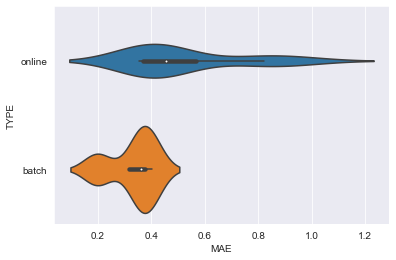

In [65]:
sns.violinplot(x="MAE", y="TYPE", data=dati_mae_total)

<AxesSubplot:xlabel='MAE', ylabel='TYPE'>

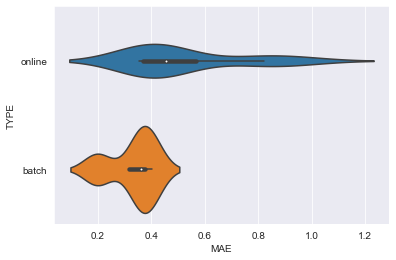

In [66]:
sns.violinplot(x="MAE", y="TYPE", data=dati_mae_total)

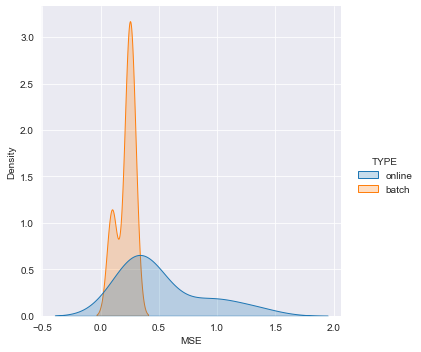

In [67]:
sns.displot(dati_mse_total, x='MSE', hue='TYPE',kind="kde", fill=True)

In [68]:

tempi_execution = {'SEC_of_execution': [
    62.4307641,
    57.864486694,
    534.30783462,
    36.50877380,
    9.591705799,
    0.0303657054,
    1.6849195957,
    0.061385631],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ],
    'NUM OF SAMPLE': [
        26256,
        26256,
        26256,
        26256,
        26256,
        26256,
        26256,
        26256
    ]
}

In [69]:
tempi_execution = pd.DataFrame(tempi_execution)

In [77]:
tempi_execution.to_csv('Risultati_Completi/ItalyPower/tempi_execution')

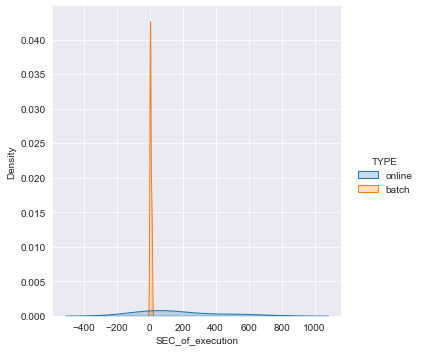

In [70]:
sns.displot(tempi_execution, x='SEC_of_execution', hue='TYPE',kind="kde", fill=True)